# Imports & helper functions

In [1]:

# Imports 
import pandas as pd
import numpy as np
import ast
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Import your evaluation functions
from parsing_and_evaluation import (
    parse_and_evaluate_boolq,
    parse_and_evaluate_trivia,
    parse_and_evaluate_squad,
    parse_and_evaluate_gsm8k
)
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [2]:
# Helper functions
def calculate_ece(df, confidence_col='parsed_confidence', correct_col='is_correct', n_bins=10):
    """
    Calculate the Expected Calibration Error (ECE) for a dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing confidence scores and correctness information
    confidence_col : str, default='parsed_confidence'
        Name of the column containing confidence scores (0-100)
    correct_col : str, default='is_correct'
        Name of the column containing boolean correctness values
    n_bins : int, default=10
        Number of bins to use for binning confidence scores
        
    Returns:
    --------
    float
        The Expected Calibration Error value
    """
    
    # Filter out rows with missing values
    df_valid = df.dropna(subset=[confidence_col, correct_col])
    
    if len(df_valid) == 0:
        return np.nan
    
    # Create bins for confidence scores
    bin_edges = np.linspace(0, 100, n_bins + 1)
    bin_indices = np.digitize(df_valid[confidence_col], bin_edges) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)  # Ensure indices are within range
    
    # Calculate ECE
    ece = 0
    total_samples = len(df_valid)
    
    for bin_idx in range(n_bins):
        # Get samples in this bin
        bin_mask = (bin_indices == bin_idx)
        bin_size = bin_mask.sum()
        
        if bin_size > 0:
            # Calculate average confidence and accuracy for this bin
            bin_conf = df_valid.loc[bin_mask, confidence_col].mean() / 100.0  # Normalize to [0,1]
            bin_acc = df_valid.loc[bin_mask, correct_col].mean()
            
            # Add weighted absolute difference to ECE
            ece += (bin_size / total_samples) * abs(bin_acc - bin_conf)
    
    return ece

def calculate_auroc(df, confidence_col='parsed_confidence', correct_col='is_correct', plot=True, title=None, save_path=None):
    """
    Calculate the Area Under the ROC Curve (AUROC) for a dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing confidence scores and correctness information
    confidence_col : str, default='parsed_confidence'
        Name of the column containing confidence scores (0-100)
    correct_col : str, default='is_correct'
        Name of the column containing boolean correctness values
    plot : bool, default=True
        Whether to plot the ROC curve
    title : str, default=None
        Title for the plot, if None a default title will be used
    save_path : str, default=None
        Path to save the figure, if None the figure will not be saved
        
    Returns:
    --------
    float
        The AUROC value
    """
    
    # Filter out rows with missing values
    df_valid = df.dropna(subset=[confidence_col, correct_col])
    
    if len(df_valid) == 0:
        return np.nan
    
    # Ensure correct_col is boolean or 0/1
    if df_valid[correct_col].dtype == bool:
        y_true = df_valid[correct_col].astype(int)
    else:
        # Handle string True/False values if present
        if isinstance(df_valid[correct_col].iloc[0], str):
            y_true = df_valid[correct_col].map({'True': 1, 'False': 0}).astype(int)
        else:
            y_true = df_valid[correct_col].astype(int)
    
    # Normalize confidence to 0-1 range
    y_score = df_valid[confidence_col] / 100.0
    
    # Calculate ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve if requested
    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                 label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                 label='Random classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
        # Set title
        if title is None:
            plt.title(f'ROC Curve (AUROC = {roc_auc:.3f})')
        else:
            plt.title(f'{title}\nAUROC = {roc_auc:.3f}')
            
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        
        # Save figure if path provided
        if save_path:
            plt.savefig(save_path, dpi=150)
            
        plt.show()
    
    return roc_auc

In [3]:
# ============================================================
# Robust uncertainty → confidence mapping (caps + options)
# ============================================================
# Goal: avoid mapping almost everything to ~1.0 confidence.
# Idea: cap the uncertainty range using robust, data-driven cutoffs
#       (quantiles + IQR rule), optionally log-transform, then
#       min–max to [0,1] and invert to confidence.
#
# You can tune via UNC_CONF_OPTS below.
# ------------------------------------------------------------
def _answers_list(x):
    if isinstance(x, list): return x
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x)
            return v if isinstance(v, list) else [v]
        except Exception:
            return [x]
    return [] if pd.isna(x) else [x]

def boolq_normalize(s: str) -> str:
    s = str(s).strip().lower()
    if s in {"true", "yes", "y", "1"}:  return "true"
    if s in {"false","no", "n", "0"}:   return "false"
    # fallback: try to detect embedded yes/no
    if " yes" in f" {s} " or s.startswith("yes"):  return "true"
    if " no"  in f" {s} " or s.startswith("no"):   return "false"
    return s

def _auto_unc_caps(u: pd.Series, lower_q=0.02, upper_q=0.98):
    """
    Pick robust caps for uncertainty:
      - Start with lower/upper quantiles
      - Apply Tukey fences (IQR rule) and take the *tighter* upper cap
      - Ensure lower < upper (fallback to min/max if needed)
    Returns (lower_cap, upper_cap)
    """
    u = pd.to_numeric(u, errors="coerce").dropna()
    if u.empty:
        return 0.0, 1.0

    q1, q3 = u.quantile(0.25), u.quantile(0.75)
    iqr = q3 - q1
    low_q  = u.quantile(lower_q)
    high_q = u.quantile(upper_q)

    # Tukey fences
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr

    lower_cap = max(low_q, lower_fence)
    upper_cap = min(high_q, upper_fence)

    # guard
    if not np.isfinite(lower_cap): lower_cap = low_q
    if not np.isfinite(upper_cap): upper_cap = high_q
    if upper_cap <= lower_cap:
        lower_cap, upper_cap = u.min(), u.max() + 1e-9  # tiny spread

    return float(lower_cap), float(upper_cap)


def _unc_to_conf01(
    u: pd.Series,
    strategy: str = "auto_quantile",
    lower_q: float = 0.02,
    upper_q: float = 1,
    log_transform: bool = True,
    gamma: float = 1.0,
):
    """
    Map arbitrary positive uncertainty → confidence in [0,1].

    strategy="auto_quantile":
        - (optional) log1p-transform to compress heavy tail
        - choose robust caps via _auto_unc_caps(lower_q, upper_q)
        - clip to [lower_cap, upper_cap]
        - min–max scale to [0,1] → invert to 1 - norm
        - optional power transform (gamma): conf = conf ** gamma
          (gamma>1 pulls high confidences down; gamma<1 pushes them up)

    Parameters
    ----------
    u : pd.Series of uncertainty_score
    lower_q, upper_q : float
        Quantiles used for initial caps (default 2% and 98%)
    log_transform : bool
        If True, apply log1p after shifting to keep positivity
    gamma : float
        Power adjustment on resulting confidence (>=0). Use 1.2–1.5
        to reduce the pile-up near 1.0.

    Returns
    -------
    pd.Series in [0,1]
    """
    u = pd.to_numeric(u, errors="coerce")

    # optional log1p to compress heavy tails
    if log_transform:
        # shift so min >= 0 before log
        shift = max(0.0, -float(u.min())) + 1e-9
        u_work = np.log1p(u + shift)
    else:
        u_work = u.copy()

    # robust caps
    if strategy == "auto_quantile":
        lo, hi = _auto_unc_caps(u_work, lower_q=lower_q, upper_q=upper_q)
    else:
        # fallback to naive min-max
        lo, hi = float(u_work.min()), float(u_work.max()) + 1e-9

    # clip and min–max
    u_clip = u_work.clip(lo, hi)
    norm = (u_clip - lo) / (hi - lo + 1e-12)
    conf = 1.0 - norm  # invert: lower uncertainty -> higher confidence

    # power adjustment (gamma>1 flattens near 1.0)
    if gamma is not None and gamma > 0:
        conf = np.power(conf, gamma)

    return pd.Series(conf, index=u.index).clip(0, 1)


def _json_answer_conf(ans: str, conf_pct: float) -> str:
    # Synthesize parser-friendly JSON for the universal parser in parsing_and_evaluation.py
    return json.dumps(
        {"answer": str(ans), "confidence": int(np.clip(round(conf_pct), 0, 100))},
        ensure_ascii=False
    )


# ---- Tuning knobs for the mapping (you can tweak) ----
UNC_CONF_OPTS = dict(
    strategy="auto_quantile",  # robust capping
    lower_q=0.0,
    upper_q=0.98,
    log_transform=False,        # compress heavy tails
    gamma=0,                # >1 to reduce pile-up near 1.0
)


def load_and_prepare(dataset: str, path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # 1) confidence from uncertainty_score only (ROBUST)
    conf01 = _unc_to_conf01(
        df["uncertainty_score"],
        strategy=UNC_CONF_OPTS["strategy"],
        lower_q=UNC_CONF_OPTS["lower_q"],
        upper_q=UNC_CONF_OPTS["upper_q"],
        log_transform=UNC_CONF_OPTS["log_transform"],
        gamma=UNC_CONF_OPTS["gamma"],
    )
    df["parsed_confidence"] = (conf01 * 100.0).astype(float)

    # 2) plug model_answer as parsed_answer & also synthesize model_output JSON
    df["parsed_answer"] = df.get("model_answer", "").astype(str)
    df["model_output"] = [
        _json_answer_conf(a, c) for a, c in zip(df["parsed_answer"], df["parsed_confidence"])
    ]

    # 3) Gold fields per dataset
    if dataset in {"boolq", "gsm8k"}:
        if "answer" not in df.columns:
            raise ValueError("BoolQ CSV must contain 'answer'.")
    elif dataset in {"trivia","squad"}:
        if "answers" not in df.columns:
            raise ValueError(f"{dataset} CSV must contain 'answers'.")
        df["answers"] = df["answers"].apply(_answers_list)
    else:
        raise ValueError(f"Unknown dataset: {dataset}")

    df["dataset"] = dataset
    return df


# Re-run the prep with robust mapping
# dfs_raw = {ds: load_and_prepare(ds, path) for ds, path in COCOA_FILES.items()}

# Analyze CoCoA results for boolq, trivia and squad

In [4]:
# -------------------------
# 0) Config
# -------------------------
COCOA_FILES = {
    "boolq": "output/polygraph/CoCoaMSP/boolq_llama_3.2_3b_instruct_CocoaMSP_500.csv",
    "trivia": "output/polygraph/CoCoaMSP/trivia_llama_3.2_3b_instruct_CocoaMSP_500.csv",
    "squad": "output/polygraph/CoCoaMSP/squad_llama_3.2_3b_instruct_CocoaMSP_500.csv",
    "gsm8k": "output/polygraph/CoCoaMSP/gsm8k_llama_3.2_3b_instruct_CocoaMSP_510.csv"
}
SAVE_DIR = "figures/metrics/cocoa"
os.makedirs(SAVE_DIR, exist_ok=True)


## Data loading and preparation function

In [5]:
# Run the prep
dfs_raw = {ds: load_and_prepare(ds, path) for ds, path in COCOA_FILES.items()}

In [7]:
dfs_raw["gsm8k"]

,question,answer,numeric_answer,question_id,input_text,model_answer,uncertainty_score,model_output,dataset,model_id,ue_method,schema_version,timestamp,parsed_confidence,parsed_answer
0,Susie's pet lizard Moe takes 10 seconds to eat...,If it takes Moe 10 seconds to eat 40 cuttlebon...,200,2782,You are a math problem solver. Solve the follo...,800 / 40 = 20. 20 * 10 = 200. The answer is 200.,5.257464,"{""answer"": ""800 / 40 = 20. 20 * 10 = 200. The ...",gsm8k,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-09-04 14:23:47,90.644966,800 / 40 = 20. 20 * 10 = 200. The answer is 200.
1,A particular train has some passenger cars and...,First find the number of cars not counting the...,44,5678,You are a math problem solver. Solve the follo...,36\n\nStep 1: Let's denote the number of passe...,27.535385,"{""answer"": ""36\n\nStep 1: Let's denote the num...",gsm8k,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-09-04 14:23:47,26.834028,36\n\nStep 1: Let's denote the number of passe...
2,Katarina has 5 less cookies than Max has. Max ...,Max’s has a total of 68+5 = <<68+5=73>>73 cook...,298,8154,You are a math problem solver. Solve the follo...,176\nStep-by-step solution:\n## Step 1: Determ...,12.920765,"{""answer"": ""176\nStep-by-step solution:\n## St...",gsm8k,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-09-04 14:23:47,68.694874,176\nStep-by-step solution:\n## Step 1: Determ...
3,Cortney is downloading some files to her compu...,The first file will take 80/2= <<80/2=40>>40 m...,2,5981,You are a math problem solver. Solve the follo...,Step 1: Calculate the total size of the files ...,5.864386,"{""answer"": ""Step 1: Calculate the total size o...",gsm8k,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-09-04 14:23:47,88.906552,Step 1: Calculate the total size of the files ...
4,Harly's animal shelter has 80 dogs. She adopts...,First find how many dogs are adopted out: 80 d...,53,5917,You are a math problem solver. Solve the follo...,80 - 0.4(80) - 5 = 80 - 32 - 5 = 43. \n\nExpla...,9.311426,"{""answer"": ""80 - 0.4(80) - 5 = 80 - 32 - 5 = 4...",gsm8k,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-09-04 14:23:47,79.033150,80 - 0.4(80) - 5 = 80 - 32 - 5 = 43. \n\nExpla...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,"A local restaurant was offering a ""Build Your ...",She orders 2 scoops of ice cream that's $1.00 ...,7,2376,You are a math problem solver. Solve the follo...,$8.00\nExplanation: \nStep 1: Calculate the c...,14.016642,"{""answer"": ""$8.00\nExplanation: \nStep 1: Cal...",gsm8k,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-09-04 15:08:21,65.555940,$8.00\nExplanation: \nStep 1: Calculate the c...
506,Charlie can make 5350 steps while running on a...,Charlie's steps for 3 kilometers is 5350 x 2 =...,13375,6649,You are a math problem solver. Solve the follo...,"5350 × 2 1/2 = 5350 × 5/2 = 5350 × 2.5 = 13,37...",3.475832,"{""answer"": ""5350 × 2 1/2 = 5350 × 5/2 = 5350 ×...",gsm8k,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-09-04 15:08:21,95.748117,"5350 × 2 1/2 = 5350 × 5/2 = 5350 × 2.5 = 13,37..."
507,Claire wants to make 2 cakes for her mother. T...,She needs 2*2=<<2*2=4>>4 packages of flour for...,12,2500,You are a math problem solver. Solve the follo...,$120\nExplanation: \nStep 1: Calculate the num...,9.427299,"{""answer"": ""$120\nExplanation: \nStep 1: Calcu...",gsm8k,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-09-04 15:08:21,78.701252,$120\nExplanation: \nStep 1: Calculate the num...
508,Bill put his french fries in the oven after it...,"Each minute last 60 seconds, so that means for...",255,769,You are a math problem solver. Solve the follo...,"315. No, that is incorrect. The correct answ...",26.468582,"{""answer"": ""315. No, that is incorrect. The ...",gsm8k,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-09-04 15:08:21,29.889686,"315. No, that is incorrect. The correct answ..."


## Evaluation and summaries

In [8]:
# --- Evaluate via parsing_and_evaluation (uses fuzzy matching for trivia/squad) ---

def evaluate_with_parsers(df: pd.DataFrame, dataset: str) -> pd.DataFrame:
    """
    We *reuse* the parser/evaluator so the same fuzzy/exact rules are applied.
    We already prepared model_output containing {"answer": ..., "confidence": ...}.
    """
    if dataset == "boolq":
        # gold in 'answer'
        if "answer" not in df.columns:
            raise ValueError("BoolQ CSV must contain column 'answer'")
        df["gold_bool"] = df["answer"].apply(boolq_normalize)
        df["pred_bool"] = df["parsed_answer"].apply(boolq_normalize)
        df["is_correct"] = (df["pred_bool"] == df["gold_bool"]).astype(int)
        df_eval = df.copy()
    elif dataset == "trivia":
        df_eval = parse_and_evaluate_trivia(df.copy())
    elif dataset == "squad":
        # Use remove_unanswerable=True if you want to drop unanswerables
        df_eval = parse_and_evaluate_squad(df.copy(), remove_unanswerable=True)
    elif dataset == "gsm8k":
        df_eval = parse_and_evaluate_gsm8k(df.copy())

        if "numeric_answer" not in df.columns:
            raise ValueError("GSM8K CSV must contain column 'numeric_answer'")

        # First pass: normal parsed evaluation
        df_eval["is_correct"] = (df_eval["parsed_answer"] == df_eval["numeric_answer"]).astype(int)

        # Second pass: re-evaluate wrong cases with last numeric in model_answer
        def extract_last_number(text: str):
            if not isinstance(text, str):
                return None
            nums = re.findall(r"-?\d+(?:\.\d+)?", text)
            return float(nums[-1]) if nums else None

        mask_wrong = df_eval["is_correct"] == 0
        last_nums = df_eval.loc[mask_wrong, "model_answer"].apply(extract_last_number)

        # Replace is_correct if last number matches numeric_answer
        df_eval.loc[mask_wrong, "is_correct"] = (
            last_nums == df_eval.loc[mask_wrong, "numeric_answer"].astype(float)
        ).astype(int)
        

    else:
        raise ValueError(dataset)

    # Trust our uncertainty-derived confidence if parser's confidence is NaN:
    # Keep the parser's parsed_answer (it may normalize), but ensure parsed_confidence is numeric [0,100].
    if "parsed_confidence" in df_eval.columns:
        # if parser returned NaNs, backfill with our computed values
        backfill = pd.to_numeric(df["parsed_confidence"], errors="coerce")
        df_eval["parsed_confidence"] = pd.to_numeric(df_eval["parsed_confidence"], errors="coerce")
        df_eval["parsed_confidence"] = df_eval["parsed_confidence"].fillna(backfill)
        df_eval["parsed_confidence"] = df_eval["parsed_confidence"].clip(0,100)
    else:
        df_eval["parsed_confidence"] = pd.to_numeric(df["parsed_confidence"], errors="coerce").clip(0,100)

    # Drop rows without both fields
    df_eval = df_eval.dropna(subset=["parsed_confidence", "is_correct"])
    return df_eval

eval_dfs = {ds: evaluate_with_parsers(df, ds) for ds, df in dfs_raw.items()}
for ds, d in eval_dfs.items():
    print(ds, d.shape, "cols:", list(d.columns)[:12], "...")


Removed 190 unanswerable questions. 310 questions remaining.
boolq (500, 20) cols: ['question', 'title', 'answer', 'passage', 'context', 'question_id', 'input_text', 'model_answer', 'uncertainty_score', 'model_output', 'dataset', 'model_id'] ...
trivia (500, 16) cols: ['question', 'question_id', 'question_source', 'answers', 'input_text', 'model_answer', 'uncertainty_score', 'model_output', 'dataset', 'model_id', 'ue_method', 'schema_version'] ...
squad (310, 19) cols: ['id', 'title', 'question', 'context', 'answers', 'is_impossible', 'question_id', 'input_text', 'model_answer', 'uncertainty_score', 'model_output', 'dataset'] ...
gsm8k (510, 16) cols: ['question', 'answer', 'numeric_answer', 'question_id', 'input_text', 'model_answer', 'uncertainty_score', 'model_output', 'dataset', 'model_id', 'ue_method', 'schema_version'] ...


In [11]:
# Calculate average trivia accuracy for only the cases with confidence > 0.8
trivia_high_conf = eval_dfs["trivia"][eval_dfs["trivia"]["parsed_confidence"] > 80]
trivia_accuracy_high_conf = trivia_high_conf["is_correct"].mean()
print(f"Trivia Accuracy (Confidence > 80): {trivia_accuracy_high_conf * 100:.2f}%")
print(f"remaining samples: {len(trivia_high_conf)} out of {len(eval_dfs['trivia'])}")

# Same for squad, boolq and gsm8k
squad_high_conf = eval_dfs["squad"][eval_dfs["squad"]["parsed_confidence"] > 80]
squad_accuracy_high_conf = squad_high_conf["is_correct"].mean()
print(f"Squad Accuracy (Confidence > 80): {squad_accuracy_high_conf * 100:.2f}%")
print(f"remaining samples: {len(squad_high_conf)} out of {len(eval_dfs['squad'])}")
boolq_high_conf = eval_dfs["boolq"][eval_dfs["boolq"]["parsed_confidence"] > 80]
boolq_accuracy_high_conf = boolq_high_conf["is_correct"].mean()
print(f"BoolQ Accuracy (Confidence > 80): {boolq_accuracy_high_conf * 100:.2f}%")
print(f"remaining samples: {len(boolq_high_conf)} out of {len(eval_dfs['boolq'])}")
gsm8k_high_conf = eval_dfs["gsm8k"][eval_dfs["gsm8k"]["parsed_confidence"] > 80]
gsm8k_accuracy_high_conf = gsm8k_high_conf["is_correct"].mean()
print(f"GSM8K Accuracy (Confidence > 80): {gsm8k_accuracy_high_conf * 100:.2f}%")
print(f"remaining samples: {len(gsm8k_high_conf)} out of {len(eval_dfs['gsm8k'])}")

Trivia Accuracy (Confidence > 80): 87.12%
remaining samples: 264 out of 500
Squad Accuracy (Confidence > 80): 95.98%
remaining samples: 224 out of 310
BoolQ Accuracy (Confidence > 80): 90.85%
remaining samples: 164 out of 500
GSM8K Accuracy (Confidence > 80): 89.18%
remaining samples: 194 out of 510


In [13]:
# --- Summaries (Accuracy / Avg_Confidence / ECE / AUROC) ---

def summarize(df_eval: pd.DataFrame, dataset: str) -> dict:
    return {
        "Dataset": dataset,
        "Accuracy": df_eval["is_correct"].mean(),
        "Avg_uncertainty": df_eval["uncertainty_score"].mean(),
        "Avg_Confidence": (df_eval["parsed_confidence"]/100.0).mean(),
        "ECE": calculate_ece(df_eval, confidence_col="parsed_confidence", correct_col="is_correct", n_bins=10),
        "AUROC": calculate_auroc(df_eval, confidence_col="parsed_confidence", correct_col="is_correct", plot=False),
        "N": len(df_eval)
    }

summary_df = pd.DataFrame([summarize(eval_dfs[ds], ds) for ds in ["boolq","trivia","squad", "gsm8k"]])\
             .sort_values("Dataset").reset_index(drop=True)
display(summary_df)

summary_df.to_csv("tables/metrics/CoCoA/summary_cocoa_metrics_robust.csv")

,Dataset,Accuracy,Avg_uncertainty,Avg_Confidence,ECE,AUROC,N
0,boolq,0.790000,0.622359,0.630058,0.159942,0.687257,500
1,gsm8k,0.680392,14.657973,0.652192,0.080898,0.786240,510
2,squad,0.890323,0.476057,0.832290,0.061774,0.844043,310
3,trivia,0.608000,3.437318,0.686620,0.166740,0.841098,500


## Visualizations

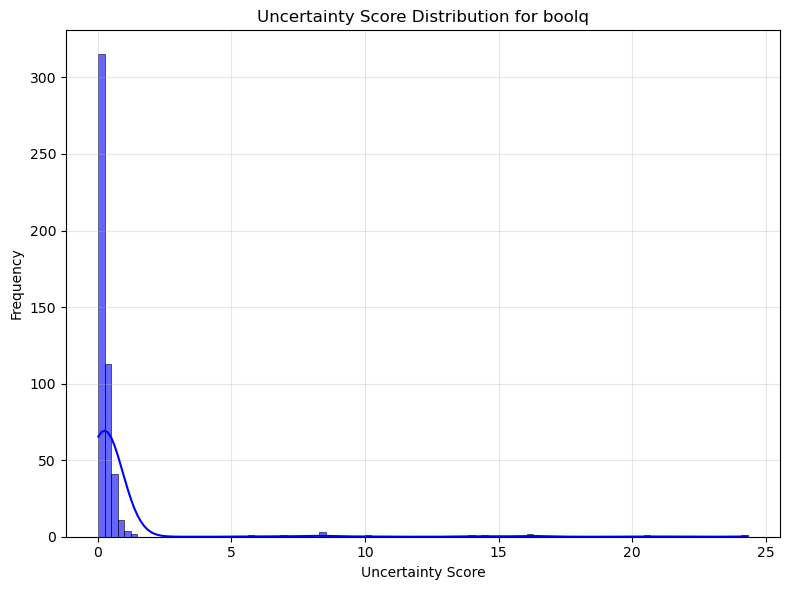

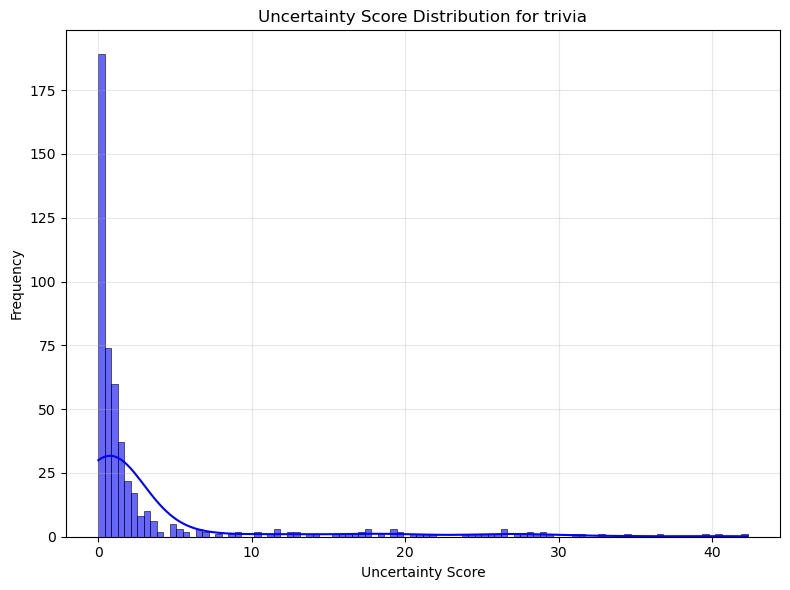

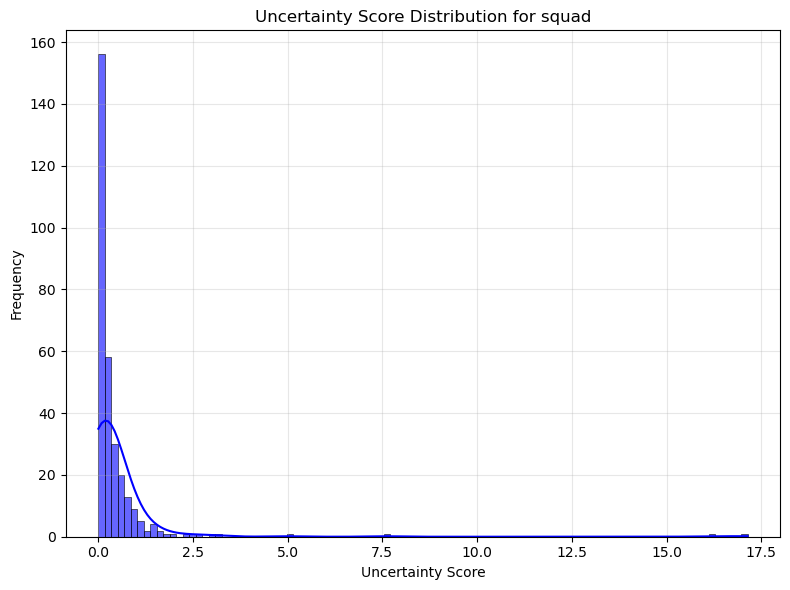

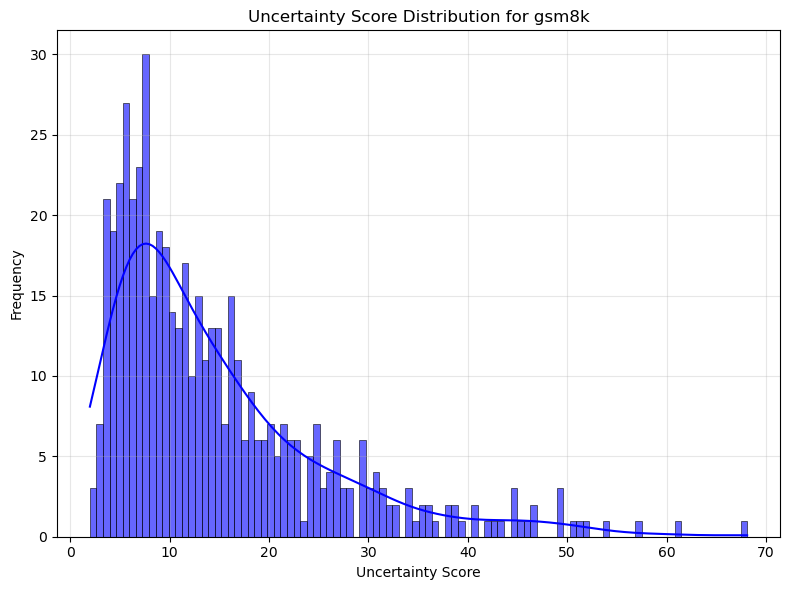

In [14]:
# Plot distribution of uncertainty scores for each dataset
def plot_uncertainty_distribution(df_eval: pd.DataFrame, dataset: str):
    plt.figure(figsize=(8, 6))
    sns.histplot(df_eval["uncertainty_score"], bins=100, kde=True, color='blue', alpha=0.6)
    plt.title(f'Uncertainty Score Distribution for {dataset}')
    plt.xlabel('Uncertainty Score')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
for ds, df_eval in eval_dfs.items():
    plot_uncertainty_distribution(df_eval, ds)
    # Save each plot
    # plt.savefig(os.path.join(SAVE_DIR, f"uncertainty_distribution_{ds}.png"), dpi=150)
    plt.close()  # Close the plot to free memory


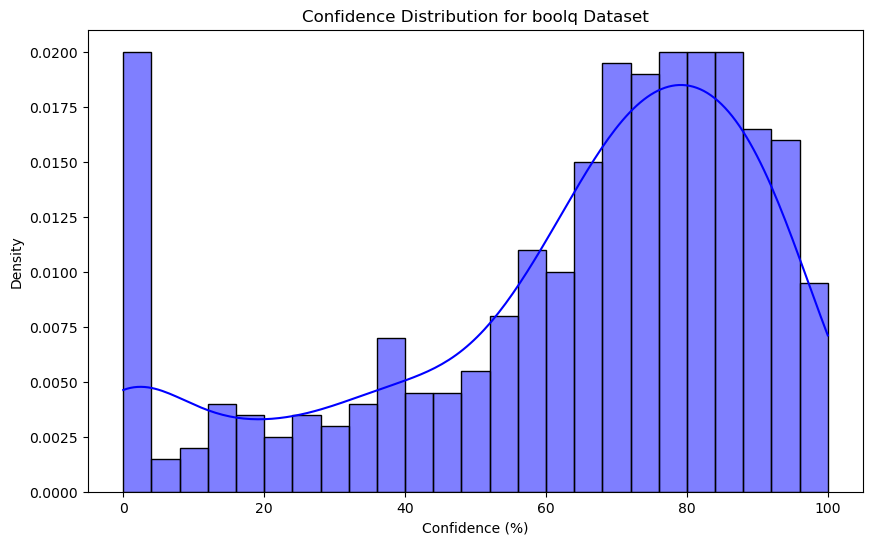

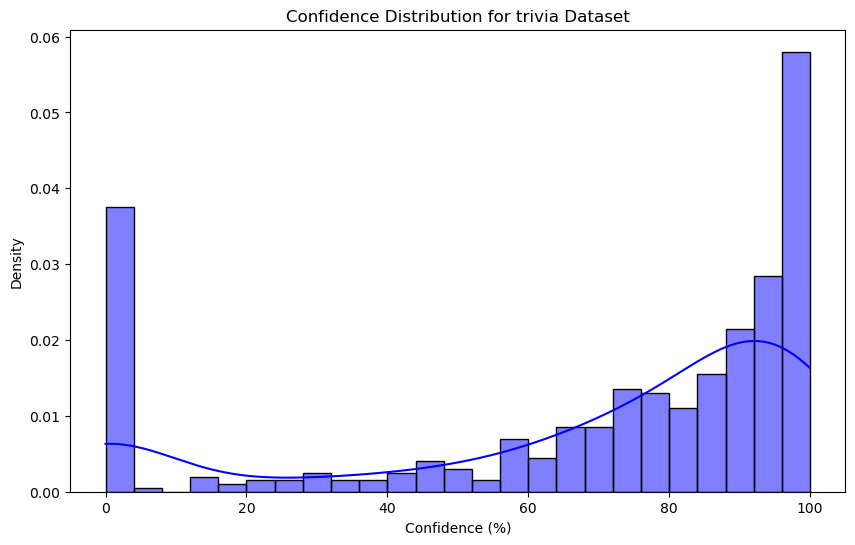

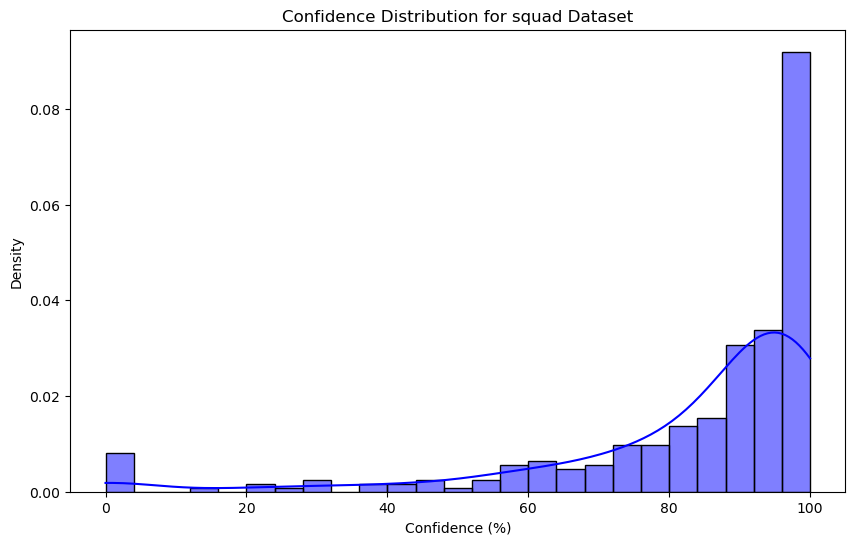

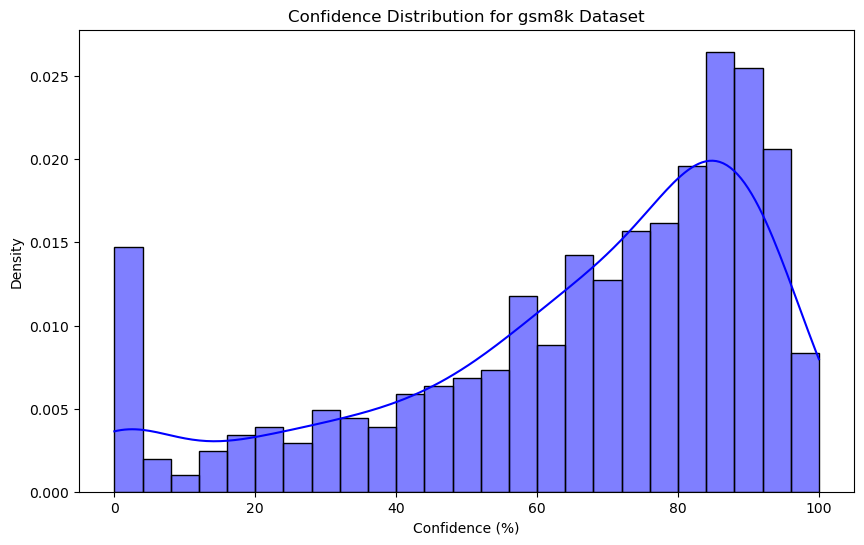

In [15]:
# Plot distribution of confidence for each dataset
def plot_confidence_distribution(df_eval: pd.DataFrame, dataset: str, n_bins: int = 25, filter_min: float = None, filter_max: float = None, save_prefix: str = ""):
    """
    Plot the distribution of confidence scores for a given dataset.
    
    Parameters:
    -----------
    df_eval : pandas.DataFrame
        DataFrame containing parsed confidence scores and correctness information
    dataset : str
        Name of the dataset (e.g., 'boolq', 'trivia', 'squad')
    n_bins : int, default=25
        Number of bins for the histogram
    filter_min : float, optional
        Minimum confidence to include in the plot (default: None)
    filter_max : float, optional
        Maximum confidence to include in the plot (default: None)
    save_prefix : str, default=""
        Prefix for saving the figure file
    """
    
    plt.figure(figsize=(10, 6))
    
    # Filter data if specified
    if filter_min is not None:
        df_eval = df_eval[df_eval["parsed_confidence"] >= filter_min * 100]
    if filter_max is not None:
        df_eval = df_eval[df_eval["parsed_confidence"] <= filter_max * 100]
    
    sns.histplot(df_eval["parsed_confidence"], bins=n_bins, kde=True, stat="density", color="blue", edgecolor="black")
    
    plt.title(f"Confidence Distribution for {dataset} Dataset")
    plt.xlabel("Confidence (%)")
    plt.ylabel("Density")
    
    # Save figure if prefix provided
    # if save_prefix:
    #   plt.savefig(os.path.join(SAVE_DIR, f"{save_prefix}{dataset}_confidence_distribution.png"), dpi=150)
    
    plt.show()

# Plot confidence distribution for each dataset
for ds in ["boolq", "trivia", "squad", "gsm8k"]:
    plot_confidence_distribution(eval_dfs[ds], ds, n_bins=25, filter_min=0.0, filter_max=100.0, save_prefix="cocoa_")

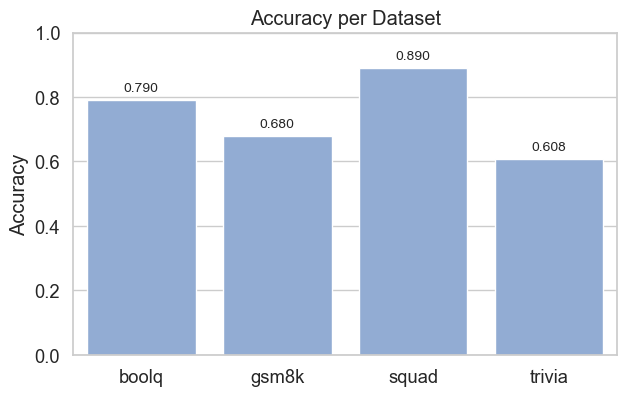

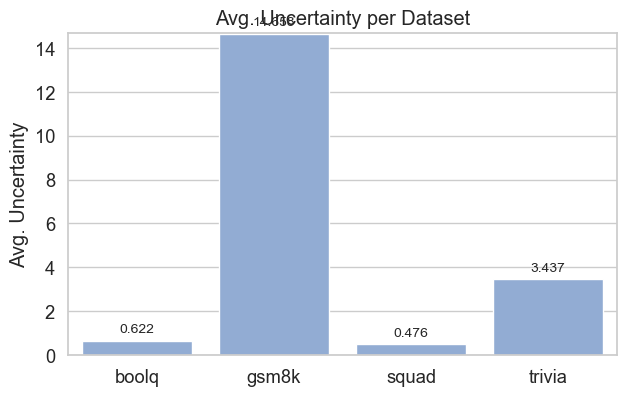

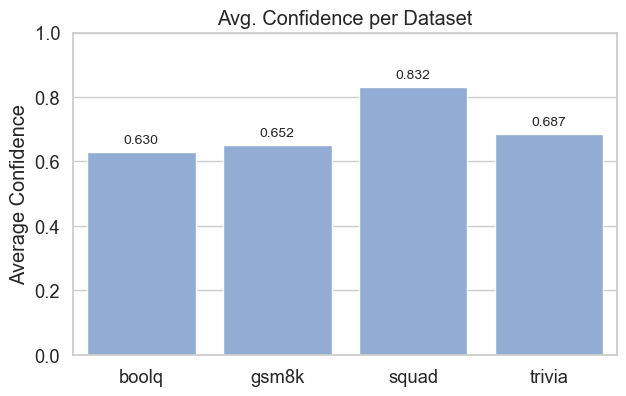

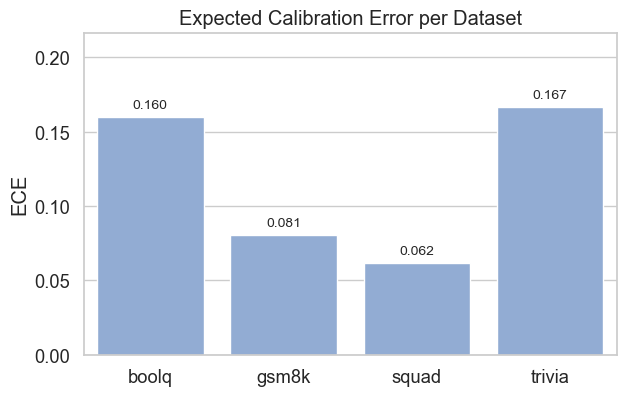

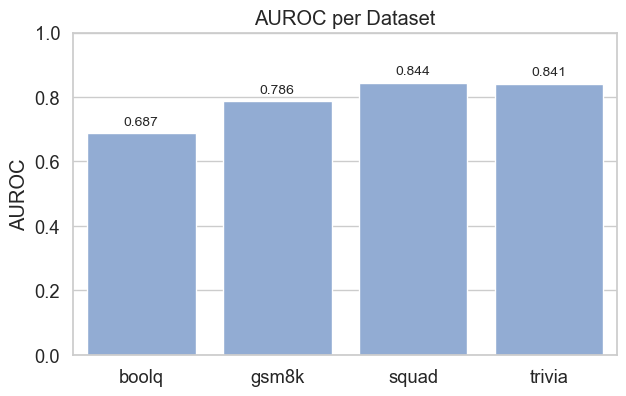

In [ ]:
# -------------------------
# Plots (same style)
# -------------------------
sns.set_theme(style="whitegrid", font_scale=1.2)

def _barplot_metric(df, metric, ylim=(0,1), fname=None, ylabel=None, title=None, color="#87aade"):
    plt.figure(figsize=(6.5,4.2))
    ax = sns.barplot(data=df, x="Dataset", y=metric, color=color)
    ax.set_ylim(*ylim)
    ax.set_ylabel(ylabel or metric)
    ax.set_xlabel("")
    if title: ax.set_title(title)
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}", (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', xytext=(0,4), textcoords='offset points', fontsize=10)
    plt.tight_layout()
    if fname:
        plt.savefig(os.path.join(SAVE_DIR, fname), dpi=300, bbox_inches="tight")
    plt.show()

_barplot_metric(summary_df, "Accuracy",        ylim=(0,1), fname="accuracy_cocoa.png",       ylabel="Accuracy",           title="Accuracy per Dataset")
_barplot_metric(summary_df, "Avg_uncertainty", ylim=(0, max(0.05, summary_df['Avg_uncertainty'].max()+0.05)), 
                fname="avg_unc_cocoa.png",       ylabel="Avg. Uncertainty",   title="Avg. Uncertainty per Dataset")
_barplot_metric(summary_df, "Avg_Confidence",  ylim=(0,1), fname="avg_conf_cocoa.png",       ylabel="Average Confidence", title="Avg. Confidence per Dataset")
_barplot_metric(summary_df, "ECE",             ylim=(0, max(0.05, summary_df['ECE'].max()+0.05)), 
                fname="ece_cocoa.png",      ylabel="ECE",                  title="Expected Calibration Error per Dataset")
_barplot_metric(summary_df, "AUROC",           ylim=(0,1), fname="auroc_cocoa.png",          ylabel="AUROC",              title="AUROC per Dataset")


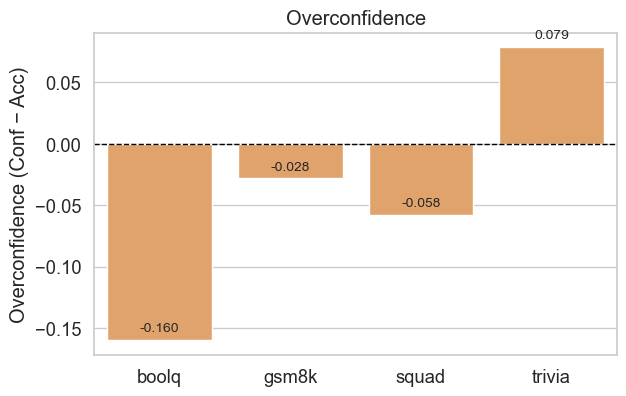

In [18]:
# -------------------------
# Overconfidence (Conf − Acc)
# -------------------------
over_df = summary_df.copy()
over_df["Overconfidence"] = over_df["Avg_Confidence"] - over_df["Accuracy"]

plt.figure(figsize=(6.5,4.2))
ax = sns.barplot(data=over_df, x="Dataset", y="Overconfidence", color="#f4a259")
ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.set_ylabel("Overconfidence (Conf − Acc)")
ax.set_xlabel("")
ax.set_title("Overconfidence")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='bottom', xytext=(0,4), textcoords='offset points', fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "overconfidence_cocoa.png"), dpi=300, bbox_inches="tight")
plt.show()


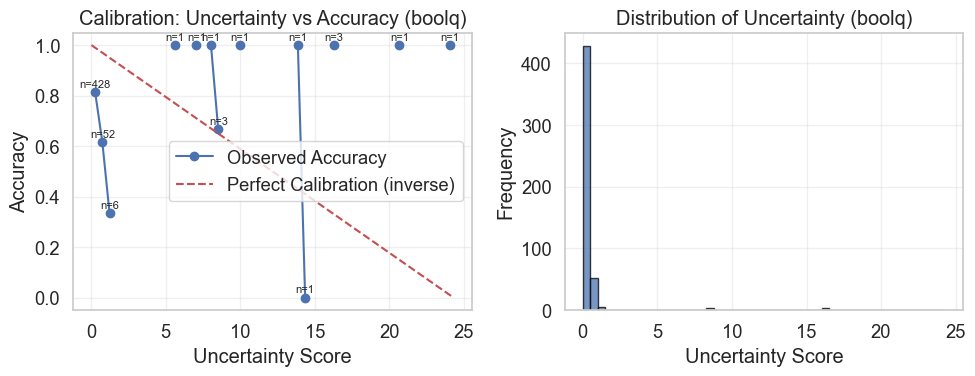

[boolq] corr(uncertainty, -correctness) = -0.006
[boolq] mean uncertainty (correct)   = 0.630
[boolq] mean uncertainty (incorrect) = 0.595


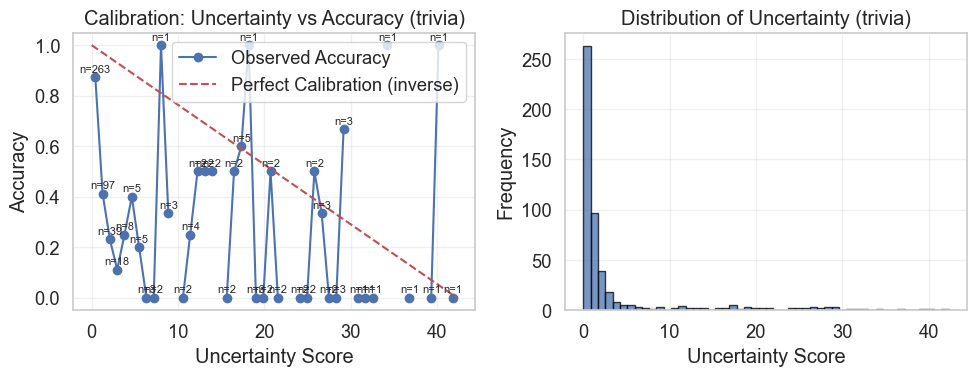

[trivia] corr(uncertainty, -correctness) = 0.296
[trivia] mean uncertainty (correct)   = 1.705
[trivia] mean uncertainty (incorrect) = 6.124


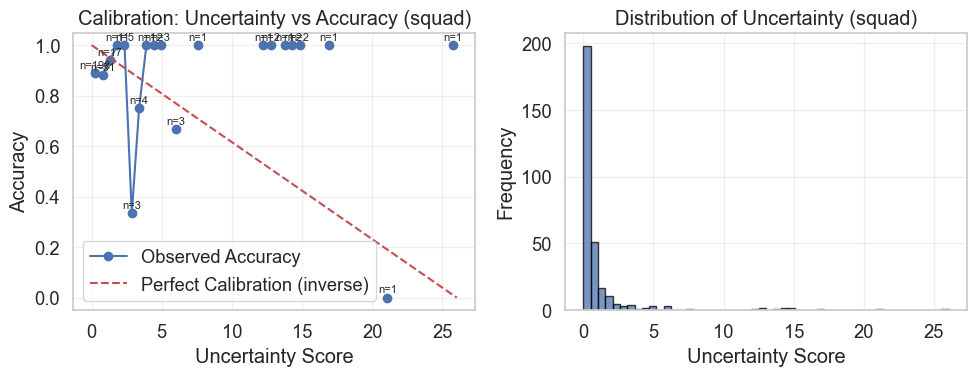

[squad] corr(uncertainty, -correctness) = 0.015
[squad] mean uncertainty (correct)   = 1.189
[squad] mean uncertainty (incorrect) = 1.334


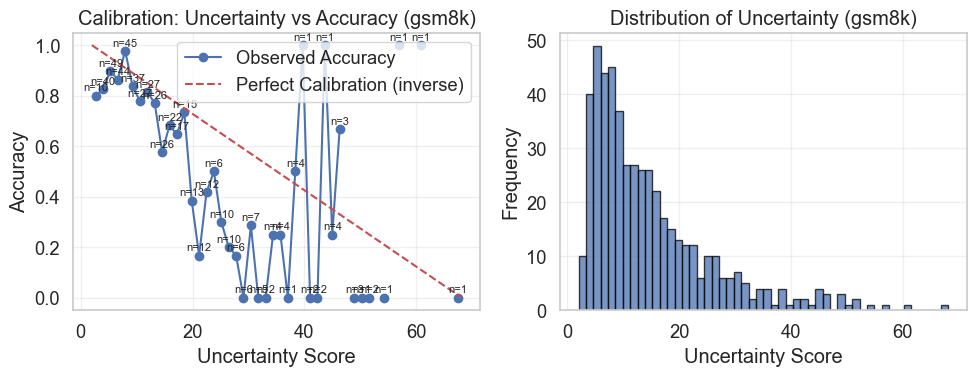

[gsm8k] corr(uncertainty, -correctness) = 0.460
[gsm8k] mean uncertainty (correct)   = 11.207
[gsm8k] mean uncertainty (incorrect) = 22.005


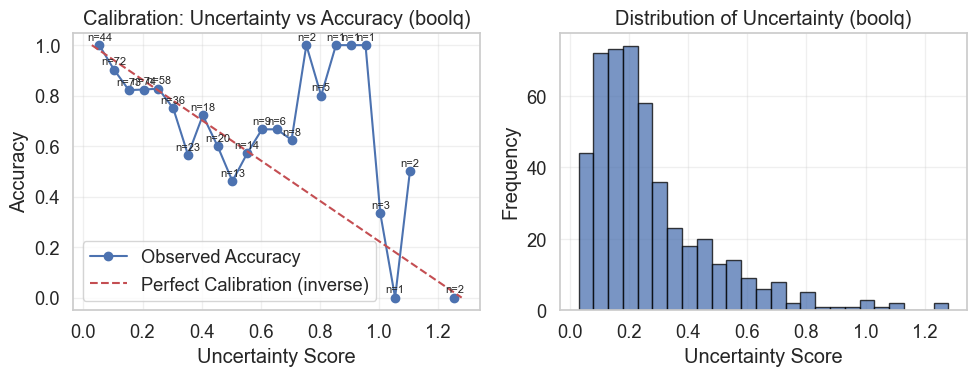

[boolq] corr(uncertainty, -correctness) = 0.278
[boolq] mean uncertainty (correct)   = 0.244
[boolq] mean uncertainty (incorrect) = 0.384


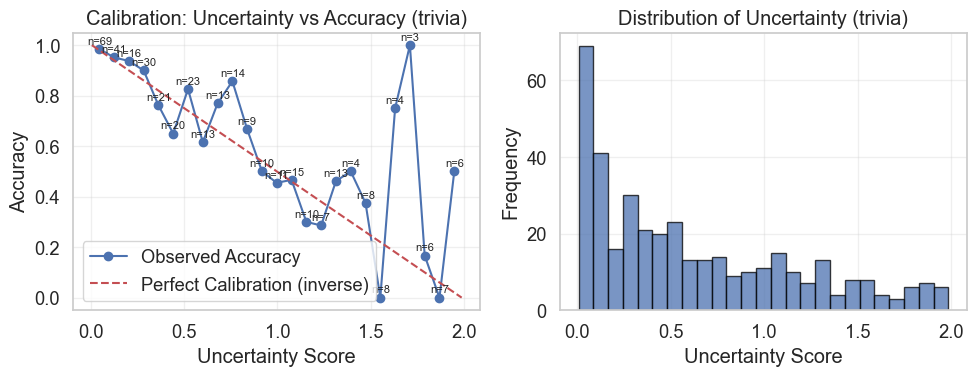

[trivia] corr(uncertainty, -correctness) = 0.518
[trivia] mean uncertainty (correct)   = 0.441
[trivia] mean uncertainty (incorrect) = 1.067


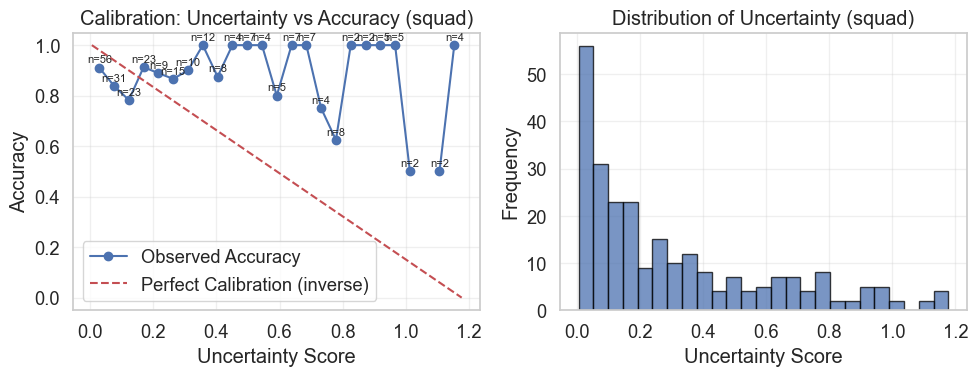

[squad] corr(uncertainty, -correctness) = -0.005
[squad] mean uncertainty (correct)   = 0.304
[squad] mean uncertainty (incorrect) = 0.300


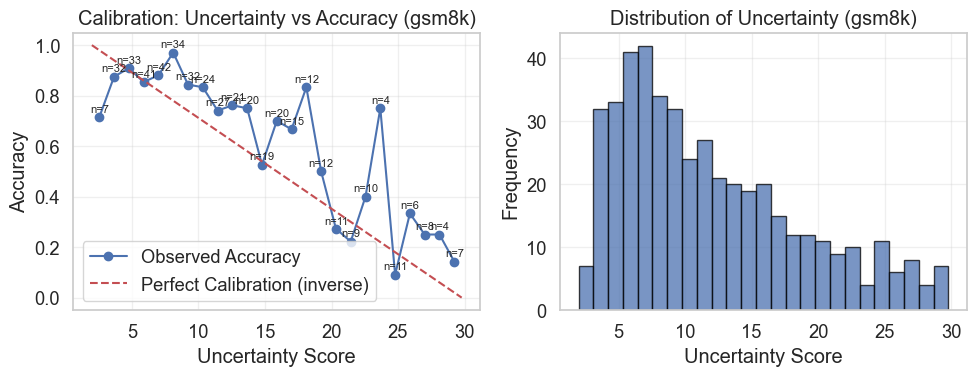

[gsm8k] corr(uncertainty, -correctness) = 0.445
[gsm8k] mean uncertainty (correct)   = 10.068
[gsm8k] mean uncertainty (incorrect) = 16.811


In [ ]:
# === Uncertainty calibration plots (Accuracy vs Uncertainty + Histogram) ===
# Per dataset, using ONLY `uncertainty_score`.
# Works with the data frames prepared above: `dfs_raw` (has uncertainty_score) and `eval_dfs` (has is_correct).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

CALIB_SAVE_DIR = os.path.join(SAVE_DIR, "calibration_uncertainty_plots")
os.makedirs(CALIB_SAVE_DIR, exist_ok=True)
CALIB_SAVE_DIR = CALIB_SAVE_DIR.replace("\\", "/")  # force forward slashes

def _assemble_uncertainty_eval_df(dataset: str) -> pd.DataFrame:
    """
    Merge raw uncertainty with correctness from the parser-evaluated df.
    Assumes row order is preserved; if not, attach an explicit row_id before evaluation.
    """
    raw = dfs_raw[dataset].reset_index(drop=True)
    eva = eval_dfs[dataset].reset_index(drop=True)
    if len(raw) != len(eva):
        # If lengths diverge (e.g., parser dropped rows), align by index subset
        n = min(len(raw), len(eva))
        raw = raw.iloc[:n].copy()
        eva = eva.iloc[:n].copy()
    out = pd.DataFrame({
        "uncertainty_score": pd.to_numeric(raw["uncertainty_score"], errors="coerce"),
        "is_correct": eva["is_correct"].astype(float)  # keep NaNs if any
    })
    # Attach parsed answer if available (for optional filtering/inspection)
    if "parsed_answer" in eva.columns:
        out["parsed_answer"] = eva["parsed_answer"]
    return out.dropna(subset=["uncertainty_score", "is_correct"]).reset_index(drop=True)

def plot_uncertainty_calibration(
    df_in: pd.DataFrame,
    dataset: str,
    n_bins: int = 25,
    filter_max: float | None = None,
    save_prefix: str | None = None
):
    """
    Make a 1x2 figure:
      (left) binned accuracy vs. uncertainty (blue line) + inverse "ideal" line
      (right) histogram of uncertainty
    If filter_max is set, restricts to uncertainty_score < filter_max.
    """
    df = df_in.copy()
    if filter_max is not None:
        df = df[df["uncertainty_score"] < filter_max].copy()

    if df.empty:
        print(f"[{dataset}] No data after filtering; skipping.")
        return

    # correlation between uncertainty and *incorrectness* (negative of correctness)
    corr = df["uncertainty_score"].corr(-df["is_correct"])

    # Build bins in *raw* uncertainty space
    u = df["uncertainty_score"].to_numpy()
    y = df["is_correct"].astype(int).to_numpy()

    # Guard: constant-uncertainty edge case
    u_min, u_max = np.nanmin(u), np.nanmax(u)
    if not np.isfinite(u_min) or not np.isfinite(u_max) or u_max <= u_min:
        u_max = u_min + 1e-6

    edges = np.linspace(u_min, u_max, n_bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])

    bin_acc = []
    bin_cnt = []
    for i in range(n_bins):
        if i == n_bins - 1:
            m = (u >= edges[i]) & (u <= edges[i + 1])
        else:
            m = (u >= edges[i]) & (u < edges[i + 1])
        if m.sum() > 0:
            bin_acc.append(y[m].mean())
            bin_cnt.append(int(m.sum()))
        else:
            bin_acc.append(np.nan)
            bin_cnt.append(0)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Left: calibration curve (uncertainty vs. accuracy)
    axes[0].plot(centers, bin_acc, "bo-", label="Observed Accuracy")
    # Heuristic "ideal" inverse trend (purely illustrative)
    axes[0].plot([u_min, u_max], [1.0, 0.0], "r--", label="Perfect Calibration (inverse)")
    axes[0].set_xlabel("Uncertainty Score")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title(f"Calibration: Uncertainty vs Accuracy ({dataset})")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Annotate bin counts
    for x, yv, c in zip(centers, bin_acc, bin_cnt):
        if np.isfinite(yv) and c > 0:
            axes[0].text(x, yv + 0.02, f"n={c}", ha="center", fontsize=8)

    # Right: histogram of uncertainty
    axes[1].hist(df["uncertainty_score"], bins=n_bins, alpha=0.75, edgecolor="black")
    axes[1].set_xlabel("Uncertainty Score")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title(f"Distribution of Uncertainty ({dataset})")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    # Save
    tag = f"{dataset}" + (f"_lt{filter_max:g}" if filter_max is not None else "")
    fname = f"{save_prefix or 'calibration'}_{tag}.png"
    plt.savefig(os.path.join(CALIB_SAVE_DIR, fname).replace("\\", "/"), dpi=300, bbox_inches="tight")
    plt.show()

    # Print small summary
    print(f"[{dataset}] corr(uncertainty, -correctness) = {corr:.3f}")
    print(f"[{dataset}] mean uncertainty (correct)   = {df[df['is_correct']==1]['uncertainty_score'].mean():.3f}")
    print(f"[{dataset}] mean uncertainty (incorrect) = {df[df['is_correct']==0]['uncertainty_score'].mean():.3f}")

# -------------------------
# Build uncertainty+correctness frames and plot for each dataset
# -------------------------
unc_eval = {ds: _assemble_uncertainty_eval_df(ds) for ds in ["boolq","trivia","squad", "gsm8k"]}

# Full-range plots
for ds in ["boolq","trivia","squad", "gsm8k"]:
    plot_uncertainty_calibration(unc_eval[ds], ds, n_bins=50, filter_max=None, save_prefix="calibration_unc")

# Optional: filtered-range plots (e.g., remove extreme tail)
FILTER_MAX = {
    "boolq": 2.0,   # tweak as you like
    "trivia": 2.0,
    "squad":  1.2,
    "gsm8k":  30
}
for ds in ["boolq","trivia","squad", "gsm8k"]:
    plot_uncertainty_calibration(unc_eval[ds], ds, n_bins=25, filter_max=FILTER_MAX[ds], save_prefix="calibration_unc_filtered")


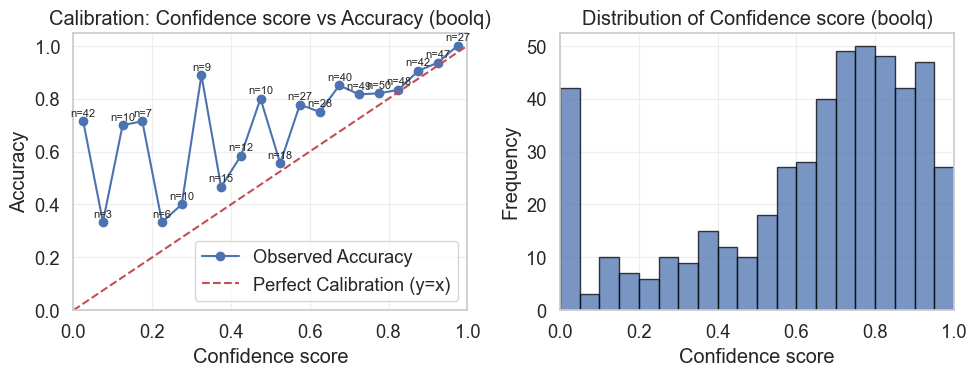

[boolq] corr(confidence, correctness) = 0.241
[boolq] mean confidence (correct)   = 0.665
[boolq] mean confidence (incorrect) = 0.499


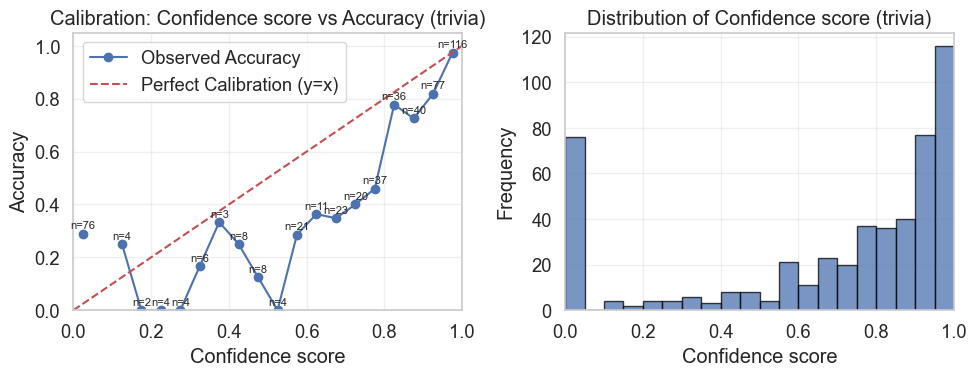

[trivia] corr(confidence, correctness) = 0.503
[trivia] mean confidence (correct)   = 0.825
[trivia] mean confidence (incorrect) = 0.472


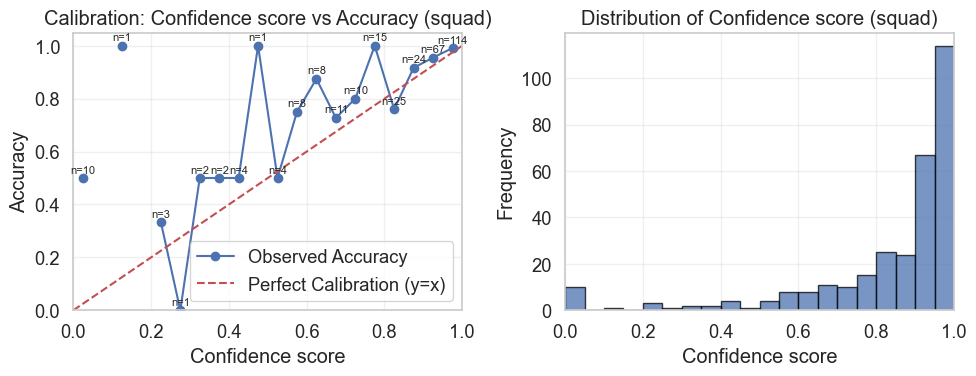

[squad] corr(confidence, correctness) = 0.438
[squad] mean confidence (correct)   = 0.867
[squad] mean confidence (incorrect) = 0.554


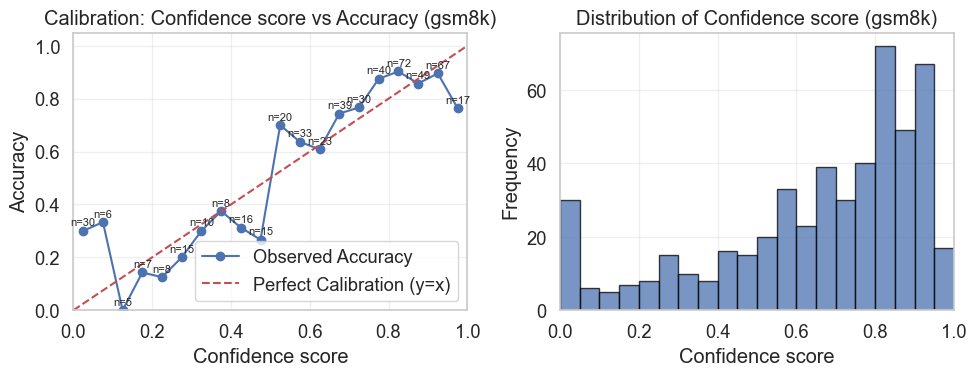

[gsm8k] corr(confidence, correctness) = 0.492
[gsm8k] mean confidence (correct)   = 0.743
[gsm8k] mean confidence (incorrect) = 0.459


In [23]:
# === Confidence-based calibration plots (like the uncertainty plots, but using confidence) ===
# Uses the "confidence score formed earlier": `parsed_confidence` in eval_dfs[ds] (0..100).
# Left: binned Accuracy vs Confidence with perfect-calibration y=x
# Right: histogram of confidence.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CALIB_CONF_SAVE_DIR = os.path.join(SAVE_DIR, "calibration_confidence_plots")
os.makedirs(CALIB_CONF_SAVE_DIR, exist_ok=True)

def _get_conf_eval_df(dataset: str) -> pd.DataFrame:
    """
    Pull the evaluated frame and keep only the columns we need.
    Assumes eval_dfs[dataset] exists and has parsed_confidence (0..100) + is_correct.
    """
    d = eval_dfs[dataset].copy()
    d = d.dropna(subset=["parsed_confidence", "is_correct"])
    d["conf01"] = pd.to_numeric(d["parsed_confidence"], errors="coerce").clip(0, 100) / 100.0
    d["is_correct"] = d["is_correct"].astype(int)
    return d[["conf01", "is_correct"]].reset_index(drop=True)

def plot_confidence_calibration(
    dataset: str,
    n_bins: int = 25,
    filter_min: float | None = None,
    filter_max: float | None = None,
    save_prefix: str = "calibration_conf"
):
    """
    Make 1x2 figure for a dataset using confidence:
      (left) binned accuracy vs confidence with y=x;
      (right) histogram of confidence.
    filter_min/max are in [0,1] for confidence (e.g., filter_min=0.1, filter_max=0.95).
    """
    df = _get_conf_eval_df(dataset)

    # Optional range filtering on confidence
    if filter_min is not None:
        df = df[df["conf01"] >= float(filter_min)]
    if filter_max is not None:
        df = df[df["conf01"] <= float(filter_max)]

    if df.empty:
        print(f"[{dataset}] No data after filtering; skipping.")
        return

    conf = df["conf01"].to_numpy()
    corr = df["conf01"].corr(df["is_correct"])  # correlation(confidence, correctness)

    # Build equal-width bins in confidence space
    edges = np.linspace(conf.min(), conf.max(), n_bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])

    bin_acc, bin_cnt = [], []
    y = df["is_correct"].to_numpy()

    for i in range(n_bins):
        if i == n_bins - 1:
            m = (conf >= edges[i]) & (conf <= edges[i+1])
        else:
            m = (conf >= edges[i]) & (conf < edges[i+1])
        if m.sum() > 0:
            bin_acc.append(y[m].mean())
            bin_cnt.append(int(m.sum()))
        else:
            bin_acc.append(np.nan)
            bin_cnt.append(0)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Left: calibration curve (confidence vs accuracy) with y=x
    axes[0].plot(centers, bin_acc, "bo-", label="Observed Accuracy")
    if filter_min is not None or filter_max is not None:
        axes[0].set_xlim(float(filter_min or 0), float(filter_max or 1))
        # Replot the perfect line with the same limits
        axes[0].plot([float(filter_min or 0), float(filter_max or 1)], [0, 1], "r--")
    else:
        axes[0].set_xlim(0, 1)
        axes[0].plot([0, 1], [0, 1], "r--", label="Perfect Calibration (y=x)")
    axes[0].set_ylim(0, 1.05)
    axes[0].set_xlabel("Confidence score")
    axes[0].set_ylabel("Accuracy")
    title_tag = f"{dataset}" + (f" [{filter_min or 0:.2f}–{filter_max or 1:.2f}]" if (filter_min is not None or filter_max is not None) else "")
    axes[0].set_title(f"Calibration: Confidence score vs Accuracy ({title_tag})")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Annotate counts
    for x, yv, c in zip(centers, bin_acc, bin_cnt):
        if np.isfinite(yv) and c > 0:
            axes[0].text(x, min(1.02, yv + 0.02), f"n={c}", ha="center", fontsize=8)

    # Right: histogram of confidence
    axes[1].hist(df["conf01"], bins=n_bins, alpha=0.75, edgecolor="black")
    if filter_min is not None or filter_max is not None:
        axes[1].set_xlim(float(filter_min or 0), float(filter_max or 1))
    else:
        axes[1].set_xlim(0, 1)
    axes[1].set_xlabel("Confidence score")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title(f"Distribution of Confidence score ({dataset})")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    fname = f"{save_prefix}_{dataset}"
    if filter_min is not None or filter_max is not None:
        lo = 0.0 if filter_min is None else float(filter_min)
        hi = 1.0 if filter_max is None else float(filter_max)
        fname += f"_range_{lo:.2f}_{hi:.2f}"
    plt.savefig(os.path.join(CALIB_CONF_SAVE_DIR, f"{fname}.png"), dpi=300, bbox_inches="tight")
    plt.show()

    # Summary lines
    print(f"[{dataset}] corr(confidence, correctness) = {corr:.3f}")
    print(f"[{dataset}] mean confidence (correct)   = {df[df['is_correct']==1]['conf01'].mean():.3f}")
    print(f"[{dataset}] mean confidence (incorrect) = {df[df['is_correct']==0]['conf01'].mean():.3f}")

# --- Generate plots for all datasets ---
for ds in ["boolq","trivia","squad", "gsm8k"]:
    # Full range
    plot_confidence_calibration(ds, n_bins=20, filter_min=None, filter_max=None, save_prefix="calibration_conf")
    # Optional filtered range (trim extreme tails if needed)
    # plot_confidence_calibration(ds, n_bins=25, filter_min=0.925, filter_max=1, save_prefix="calibration_conf_filtered")


## Experimental: Separate analysis of CoCoA results on BoolQ (discovering filtering)

In [24]:
# Use the same file path as in the first cell
results_cocoa_boolq = pd.read_csv("output/polygraph/CoCoaMSP/boolq_llama_3.2_3b_instruct_CocoaMSP_500.csv")
results_cocoa_boolq

,question,title,answer,passage,context,question_id,input_text,model_answer,uncertainty_score,model_output,dataset,model_id,ue_method,schema_version,timestamp
0,is systemic functional grammar a contemporary ...,Systemic functional grammar,True,Systemic functional grammar (SFG) is a form of...,Systemic functional grammar (SFG) is a form of...,8253,You are a reading comprehension assistant. Ans...,yes.,0.173061,"{""answer"": ""yes."", ""uncertainty_score"": 0.1730...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14
1,is season 7 the final season of true blood,True Blood (season 7),True,The seventh and final season of the HBO supern...,The seventh and final season of the HBO supern...,1626,You are a reading comprehension assistant. Ans...,yes.,0.057661,"{""answer"": ""yes."", ""uncertainty_score"": 0.0576...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14
2,are there any of the temptations still living,Otis Williams,True,Williams is best known as the founder and last...,Williams is best known as the founder and last...,4398,You are a reading comprehension assistant. Ans...,yes.,0.301521,"{""answer"": ""yes."", ""uncertainty_score"": 0.3015...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14
3,does shaving your head make lice go away,Treatment of human head lice,True,Shaving the head or cutting the hair extremely...,Shaving the head or cutting the hair extremely...,7007,You are a reading comprehension assistant. Ans...,yes.,0.081838,"{""answer"": ""yes."", ""uncertainty_score"": 0.0818...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14
4,does a turtle's shell grow with them,Turtle shell,True,The carapacial ridge has been found to play an...,The carapacial ridge has been found to play an...,1978,You are a reading comprehension assistant. Ans...,yes.,0.267189,"{""answer"": ""yes."", ""uncertainty_score"": 0.2671...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,do you get overseas service bars for korea,Overseas Service Bar,True,19-28. Overseas service bars a. Authorized wea...,19-28. Overseas service bars a. Authorized wea...,12581,You are a reading comprehension assistant. Ans...,yes.,0.122344,"{""answer"": ""yes."", ""uncertainty_score"": 0.1223...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14
496,does golden goal apply in the world cup 2018,Golden goal,False,"In February 2004, the IFAB announced that afte...","In February 2004, the IFAB announced that afte...",9890,You are a reading comprehension assistant. Ans...,no.,0.187237,"{""answer"": ""no."", ""uncertainty_score"": 0.18723...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14
497,is it safe to swim in brisbane river,Brisbane River,False,"Environmentally, the river is in a poor condit...","Environmentally, the river is in a poor condit...",10663,You are a reading comprehension assistant. Ans...,no.,0.157579,"{""answer"": ""no."", ""uncertainty_score"": 0.15757...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14
498,is a certified abstract of birth a birth certi...,Birth certificate,True,The U.S. State Department has paid close atten...,The U.S. State Department has paid close atten...,1383,You are a reading comprehension assistant. Ans...,no.,0.561403,"{""answer"": ""no."", ""uncertainty_score"": 0.56140...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14


In [25]:
# Extract yes/no from model_answer and convert to boolean
def extract_yes_no(text):
    # Search for first occurrence of yes or no (case insensitive)
    match = re.search(r'\b(yes|no)\b', str(text).lower())
    if match:
        return match.group(1) == 'yes'
    return None

# Extract uncertainty value from uncertainty_score
def extract_uncertainty(uncertainty_obj):
    # Convert to string and extract the number using regex
    uncertainty_str = str(uncertainty_obj)
    match = re.search(r'uncertainty=([\d.]+)', uncertainty_str)
    if match:
        return float(match.group(1))
    return None

# Create answer_parsed column
results_cocoa_boolq['answer_parsed'] = results_cocoa_boolq['model_answer'].apply(extract_yes_no)

# Re-evaluate match column based on answer_parsed vs answer
results_cocoa_boolq['match'] = results_cocoa_boolq['answer_parsed'] == results_cocoa_boolq['answer']

# Display the updated dataframe
results_cocoa_boolq[['question', 'answer', 'model_answer', 'answer_parsed', 'uncertainty_score', 'match']].head(15)

,question,answer,model_answer,answer_parsed,uncertainty_score,match
0,is systemic functional grammar a contemporary ...,True,yes.,True,0.173061,True
1,is season 7 the final season of true blood,True,yes.,True,0.057661,True
2,are there any of the temptations still living,True,yes.,True,0.301521,True
3,does shaving your head make lice go away,True,yes.,True,0.081838,True
4,does a turtle's shell grow with them,True,yes.,True,0.267189,True
5,does dr house die in the last episode,False,no.,False,0.435030,True
6,is hair bleach the same as regular bleach,True,no.,False,0.245703,False
7,did zidane won la liga as a coach,True,yes.,True,0.331240,True
8,has anyone won all 4 majors in the same year,True,yes.,True,0.613333,True
9,the kingdom of vijayanagar was found by two br...,True,yes.,True,0.073540,True


In [26]:
# Calculate the accuracy (match rate)
accuracy = results_cocoa_boolq['match'].mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 79.20%


<Figure size 1000x600 with 0 Axes>

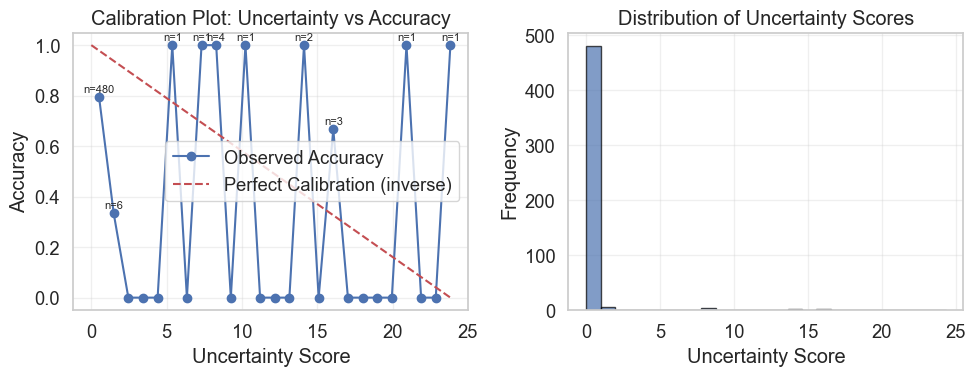

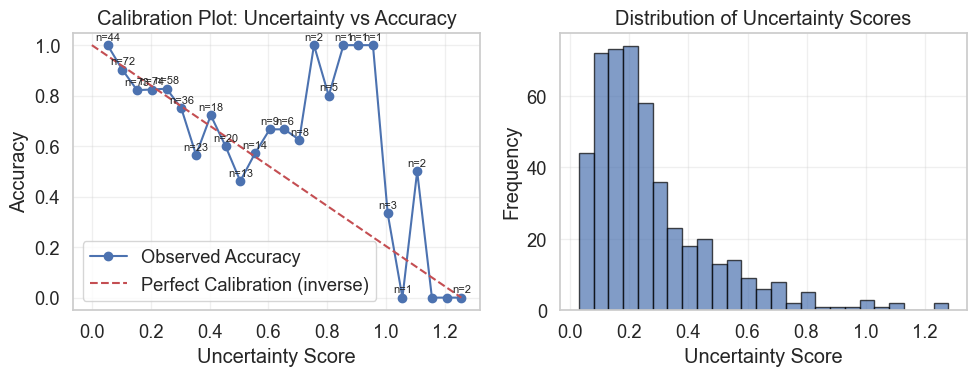

Correlation between uncertainty and correctness: -0.020
Mean uncertainty for correct answers: 0.65
Mean uncertainty for incorrect answers: 0.53


Correlation between uncertainty and correctness for filtered data: 0.278
Mean uncertainty for correct answers (filtered): 0.24
Mean uncertainty for incorrect answers (filtered): 0.38


In [27]:
# Create calibration plot for uncertainty vs correctness
plt.figure(figsize=(10, 6))

# Remove rows where answer_parsed is None for this analysis
clean_data = results_cocoa_boolq.dropna(subset=['answer_parsed'])

# filter for uncertainty scores below 1.5 and calculate correlation
filtered_data = clean_data[clean_data['uncertainty_score'] < 1.5]
correlation = filtered_data['uncertainty_score'].corr(-filtered_data['match'].astype(int))

# Continue with the analysis using filtered_data
# clean_data = filtered_data.copy()

# Create bins for uncertainty scores
n_bins = 25
bin_edges = np.linspace(clean_data['uncertainty_score'].min(), clean_data['uncertainty_score'].max(), n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate accuracy for each bin
bin_accuracies = []
bin_counts = []

for i in range(n_bins):
    # Find data points in this bin
    mask = (clean_data['uncertainty_score'] >= bin_edges[i]) & (clean_data['uncertainty_score'] < bin_edges[i+1])
    if i == n_bins - 1:  # Include right edge for last bin
        mask = (clean_data['uncertainty_score'] >= bin_edges[i]) & (clean_data['uncertainty_score'] <= bin_edges[i+1])
    
    bin_data = clean_data[mask]
    
    if len(bin_data) > 0:
        accuracy = bin_data['match'].mean()
        bin_accuracies.append(accuracy)
        bin_counts.append(len(bin_data))
    else:
        bin_accuracies.append(0)
        bin_counts.append(0)

# Create bins for uncertainty scores
n_bins = 25
bin_edges_filtered = np.linspace(filtered_data['uncertainty_score'].min(), filtered_data['uncertainty_score'].max(), n_bins + 1)
bin_centers_filtered = (bin_edges_filtered[:-1] + bin_edges_filtered[1:]) / 2

# Calculate accuracy for each bin
bin_accuracies_filtered = []
bin_counts_filtered = []

for i in range(n_bins):
    # Find data points in this bin
    mask = (filtered_data['uncertainty_score'] >= bin_edges_filtered[i]) & (filtered_data['uncertainty_score'] < bin_edges_filtered[i+1])
    if i == n_bins - 1:  # Include right edge for last bin
        mask = (filtered_data['uncertainty_score'] >= bin_edges_filtered[i]) & (filtered_data['uncertainty_score'] <= bin_edges_filtered[i+1])
    
    bin_data = filtered_data[mask]
    
    if len(bin_data) > 0:
        accuracy = bin_data['match'].mean()
        bin_accuracies_filtered.append(accuracy)
        bin_counts_filtered.append(len(bin_data))
    else:
        bin_accuracies_filtered.append(0)
        bin_counts_filtered.append(0)

# First set
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Calibration plot
axes[0].plot(bin_centers, bin_accuracies, 'bo-', label='Observed Accuracy')
axes[0].plot([0, bin_centers.max()], [1, 0], 'r--', label='Perfect Calibration (inverse)')
axes[0].set_xlabel('Uncertainty Score')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Calibration Plot: Uncertainty vs Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for x, y, count in zip(bin_centers, bin_accuracies, bin_counts):
    if count > 0:
        axes[0].text(x, y + 0.02, f'n={count}', ha='center', fontsize=8)

# Histogram
axes[1].hist(clean_data['uncertainty_score'], bins=n_bins, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Uncertainty Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Uncertainty Scores')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Second set (filtered data)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Calibration plot
axes[0].plot(bin_centers_filtered, bin_accuracies_filtered, 'bo-', label='Observed Accuracy')
axes[0].plot([0, bin_centers_filtered.max()], [1, 0], 'r--', label='Perfect Calibration (inverse)')
axes[0].set_xlabel('Uncertainty Score')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Calibration Plot: Uncertainty vs Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for x, y, count in zip(bin_centers_filtered, bin_accuracies_filtered, bin_counts_filtered):
    if count > 0:
        axes[0].text(x, y + 0.02, f'n={count}', ha='center', fontsize=8)

# Histogram
axes[1].hist(filtered_data['uncertainty_score'], bins=n_bins, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Uncertainty Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Uncertainty Scores')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Print summary statistics
print(f"Correlation between uncertainty and correctness: {clean_data['uncertainty_score'].corr(-clean_data['match'].astype(int)):.3f}")
print(f"Mean uncertainty for correct answers: {clean_data[clean_data['match']]['uncertainty_score'].mean():.2f}")
print(f"Mean uncertainty for incorrect answers: {clean_data[~clean_data['match']]['uncertainty_score'].mean():.2f}\n\n")

print(f"Correlation between uncertainty and correctness for filtered data: {filtered_data['uncertainty_score'].corr(-filtered_data['match'].astype(int)):.3f}")
print(f"Mean uncertainty for correct answers (filtered): {filtered_data[filtered_data['match']]['uncertainty_score'].mean():.2f}")
print(f"Mean uncertainty for incorrect answers (filtered): {filtered_data[~filtered_data['match']]['uncertainty_score'].mean():.2f}")

In [28]:
clean_data

,question,title,answer,passage,context,question_id,input_text,model_answer,uncertainty_score,model_output,dataset,model_id,ue_method,schema_version,timestamp,answer_parsed,match
0,is systemic functional grammar a contemporary ...,Systemic functional grammar,True,Systemic functional grammar (SFG) is a form of...,Systemic functional grammar (SFG) is a form of...,8253,You are a reading comprehension assistant. Ans...,yes.,0.173061,"{""answer"": ""yes."", ""uncertainty_score"": 0.1730...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14,True,True
1,is season 7 the final season of true blood,True Blood (season 7),True,The seventh and final season of the HBO supern...,The seventh and final season of the HBO supern...,1626,You are a reading comprehension assistant. Ans...,yes.,0.057661,"{""answer"": ""yes."", ""uncertainty_score"": 0.0576...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14,True,True
2,are there any of the temptations still living,Otis Williams,True,Williams is best known as the founder and last...,Williams is best known as the founder and last...,4398,You are a reading comprehension assistant. Ans...,yes.,0.301521,"{""answer"": ""yes."", ""uncertainty_score"": 0.3015...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14,True,True
3,does shaving your head make lice go away,Treatment of human head lice,True,Shaving the head or cutting the hair extremely...,Shaving the head or cutting the hair extremely...,7007,You are a reading comprehension assistant. Ans...,yes.,0.081838,"{""answer"": ""yes."", ""uncertainty_score"": 0.0818...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14,True,True
4,does a turtle's shell grow with them,Turtle shell,True,The carapacial ridge has been found to play an...,The carapacial ridge has been found to play an...,1978,You are a reading comprehension assistant. Ans...,yes.,0.267189,"{""answer"": ""yes."", ""uncertainty_score"": 0.2671...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,do you get overseas service bars for korea,Overseas Service Bar,True,19-28. Overseas service bars a. Authorized wea...,19-28. Overseas service bars a. Authorized wea...,12581,You are a reading comprehension assistant. Ans...,yes.,0.122344,"{""answer"": ""yes."", ""uncertainty_score"": 0.1223...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14,True,True
496,does golden goal apply in the world cup 2018,Golden goal,False,"In February 2004, the IFAB announced that afte...","In February 2004, the IFAB announced that afte...",9890,You are a reading comprehension assistant. Ans...,no.,0.187237,"{""answer"": ""no."", ""uncertainty_score"": 0.18723...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14,False,True
497,is it safe to swim in brisbane river,Brisbane River,False,"Environmentally, the river is in a poor condit...","Environmentally, the river is in a poor condit...",10663,You are a reading comprehension assistant. Ans...,no.,0.157579,"{""answer"": ""no."", ""uncertainty_score"": 0.15757...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14,False,True
498,is a certified abstract of birth a birth certi...,Birth certificate,True,The U.S. State Department has paid close atten...,The U.S. State Department has paid close atten...,1383,You are a reading comprehension assistant. Ans...,no.,0.561403,"{""answer"": ""no."", ""uncertainty_score"": 0.56140...",boolq,meta-llama/Llama-3.2-3B-Instruct,CocoaMSP,cocoa_v1,2025-08-12 19:43:14,False,False


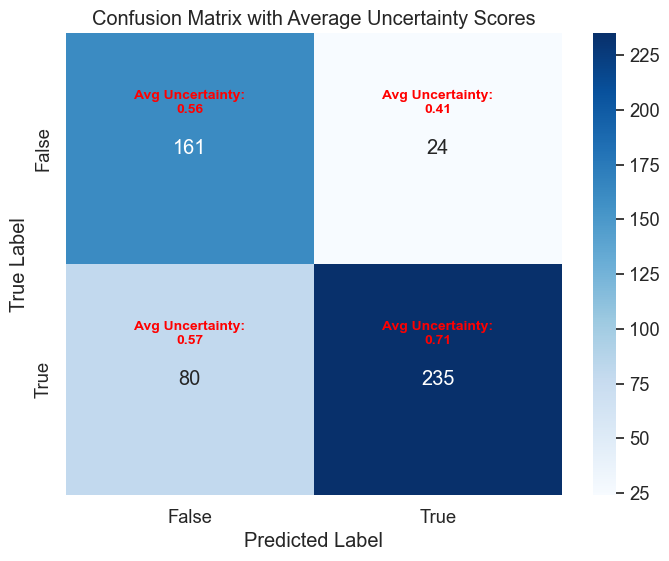

True Negatives (TN): 161 - Avg Uncertainty: 0.56
False Positives (FP): 24 - Avg Uncertainty: 0.41
False Negatives (FN): 80 - Avg Uncertainty: 0.57
True Positives (TP): 235 - Avg Uncertainty: 0.71


In [29]:
# Convert answer_parsed to boolean type
clean_data['answer_parsed'] = clean_data['answer_parsed'].astype(bool)

# Create confusion matrix
y_true = clean_data['answer']
y_pred = clean_data['answer_parsed']

cm = confusion_matrix(y_true, y_pred)

# Calculate average uncertainty for each quadrant
tn_uncertainty = clean_data[(clean_data['answer'] == False) & (clean_data['answer_parsed'] == False)]['uncertainty_score'].mean()
fp_uncertainty = clean_data[(clean_data['answer'] == False) & (clean_data['answer_parsed'] == True)]['uncertainty_score'].mean()
fn_uncertainty = clean_data[(clean_data['answer'] == True) & (clean_data['answer_parsed'] == False)]['uncertainty_score'].mean()
tp_uncertainty = clean_data[(clean_data['answer'] == True) & (clean_data['answer_parsed'] == True)]['uncertainty_score'].mean()

# Create the confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['False', 'True'], yticklabels=['False', 'True'])

# Add uncertainty annotations
plt.text(0.5, 0.3, f'Avg Uncertainty:\n{tn_uncertainty:.2f}', 
         ha='center', va='center', fontsize=10, color='red', weight='bold')
plt.text(1.5, 0.3, f'Avg Uncertainty:\n{fp_uncertainty:.2f}', 
         ha='center', va='center', fontsize=10, color='red', weight='bold')
plt.text(0.5, 1.3, f'Avg Uncertainty:\n{fn_uncertainty:.2f}', 
         ha='center', va='center', fontsize=10, color='red', weight='bold')
plt.text(1.5, 1.3, f'Avg Uncertainty:\n{tp_uncertainty:.2f}', 
         ha='center', va='center', fontsize=10, color='red', weight='bold')

plt.title('Confusion Matrix with Average Uncertainty Scores')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print detailed statistics
print(f"True Negatives (TN): {cm[0,0]} - Avg Uncertainty: {tn_uncertainty:.2f}")
print(f"False Positives (FP): {cm[0,1]} - Avg Uncertainty: {fp_uncertainty:.2f}")
print(f"False Negatives (FN): {cm[1,0]} - Avg Uncertainty: {fn_uncertainty:.2f}")
print(f"True Positives (TP): {cm[1,1]} - Avg Uncertainty: {tp_uncertainty:.2f}")

C:\Users\Chris\AppData\Local\Temp\ipykernel_74432\3064516325.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['answer_parsed'] = filtered_data['answer_parsed'].astype(bool)


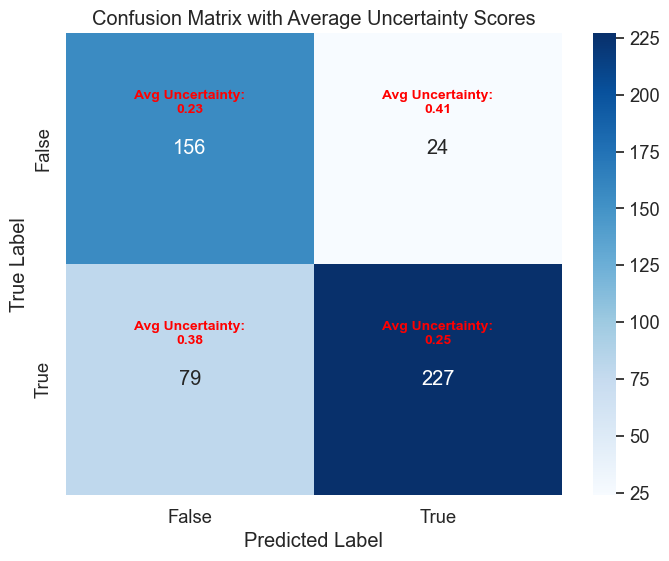

True Negatives (TN): 156 - Avg Uncertainty: 0.23
False Positives (FP): 24 - Avg Uncertainty: 0.41
False Negatives (FN): 79 - Avg Uncertainty: 0.38
True Positives (TP): 227 - Avg Uncertainty: 0.25


In [30]:
from sklearn.metrics import confusion_matrix

# Convert answer_parsed to boolean type
filtered_data['answer_parsed'] = filtered_data['answer_parsed'].astype(bool)

# Create confusion matrix
y_true = filtered_data['answer']
y_pred = filtered_data['answer_parsed']

cm = confusion_matrix(y_true, y_pred)

# Calculate average uncertainty for each quadrant
tn_uncertainty = filtered_data[(filtered_data['answer'] == False) & (filtered_data['answer_parsed'] == False)]['uncertainty_score'].mean()
fp_uncertainty = filtered_data[(filtered_data['answer'] == False) & (filtered_data['answer_parsed'] == True)]['uncertainty_score'].mean()
fn_uncertainty = filtered_data[(filtered_data['answer'] == True) & (filtered_data['answer_parsed'] == False)]['uncertainty_score'].mean()
tp_uncertainty = filtered_data[(filtered_data['answer'] == True) & (filtered_data['answer_parsed'] == True)]['uncertainty_score'].mean()

# Create the confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['False', 'True'], yticklabels=['False', 'True'])

# Add uncertainty annotations
plt.text(0.5, 0.3, f'Avg Uncertainty:\n{tn_uncertainty:.2f}', 
         ha='center', va='center', fontsize=10, color='red', weight='bold')
plt.text(1.5, 0.3, f'Avg Uncertainty:\n{fp_uncertainty:.2f}', 
         ha='center', va='center', fontsize=10, color='red', weight='bold')
plt.text(0.5, 1.3, f'Avg Uncertainty:\n{fn_uncertainty:.2f}', 
         ha='center', va='center', fontsize=10, color='red', weight='bold')
plt.text(1.5, 1.3, f'Avg Uncertainty:\n{tp_uncertainty:.2f}', 
         ha='center', va='center', fontsize=10, color='red', weight='bold')

plt.title('Confusion Matrix with Average Uncertainty Scores')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print detailed statistics
print(f"True Negatives (TN): {cm[0,0]} - Avg Uncertainty: {tn_uncertainty:.2f}")
print(f"False Positives (FP): {cm[0,1]} - Avg Uncertainty: {fp_uncertainty:.2f}")
print(f"False Negatives (FN): {cm[1,0]} - Avg Uncertainty: {fn_uncertainty:.2f}")
print(f"True Positives (TP): {cm[1,1]} - Avg Uncertainty: {tp_uncertainty:.2f}")

# Analyze MSP results
## Prepare datasets

In [4]:
# Load and prepare MSP Files
MSP_FILES = {
    "boolq": "output/polygraph/Maximum_Sequence_Probability/boolq_llama_3.2_3b_instruct_MaximumSequenceProbability_500.csv",
    "trivia": "output/polygraph/Maximum_Sequence_Probability/trivia_llama_3.2_3b_instruct_MaximumSequenceProbability_500.csv",
    "squad": "output/polygraph/Maximum_Sequence_Probability/squad_llama_3.2_3b_instruct_MaximumSequenceProbability_500.csv",
    "gsm8k": "output/polygraph/Maximum_Sequence_Probability/gsm8k_llama_3.2_3b_instruct_MaximumSequenceProbability_500.csv"
}

SAVE_DIR = "figures/metrics/msp"

In [7]:
# Run the prep
dfs_raw_msp = {ds: load_and_prepare(ds, path) for ds, path in MSP_FILES.items()}

## Evaluation and summaries

In [9]:
# --- Evaluate via parsing_and_evaluation (uses fuzzy matching for trivia/squad) ---

def evaluate_with_parsers(df: pd.DataFrame, dataset: str) -> pd.DataFrame:
    """
    We *reuse* the parser/evaluator so the same fuzzy/exact rules are applied.
    We already prepared model_output containing {"answer": ..., "confidence": ...}.
    """
    if dataset == "boolq":
        # gold in 'answer'
        if "answer" not in df.columns:
            raise ValueError("BoolQ CSV must contain column 'answer'")
        df["gold_bool"] = df["answer"].apply(boolq_normalize)
        df["pred_bool"] = df["parsed_answer"].apply(boolq_normalize)
        df["is_correct"] = (df["pred_bool"] == df["gold_bool"]).astype(int)
        df_eval = df.copy()
    elif dataset == "trivia":
        df_eval = parse_and_evaluate_trivia(df.copy())
    elif dataset == "squad":
        # Use remove_unanswerable=True if you want to drop unanswerables
        df_eval = parse_and_evaluate_squad(df.copy(), remove_unanswerable=True)
    elif dataset == "gsm8k":
        df_eval = parse_and_evaluate_gsm8k(df.copy())

        if "numeric_answer" not in df.columns:
            raise ValueError("GSM8K CSV must contain column 'numeric_answer'")

        # First pass: normal parsed evaluation
        df_eval["is_correct"] = (df_eval["parsed_answer"] == df_eval["numeric_answer"]).astype(int)

        # Second pass: re-evaluate wrong cases with last numeric in model_answer
        def extract_last_number(text: str):
            if not isinstance(text, str):
                return None
            nums = re.findall(r"-?\d+(?:\.\d+)?", text)
            return float(nums[-1]) if nums else None

        mask_wrong = df_eval["is_correct"] == 0
        last_nums = df_eval.loc[mask_wrong, "model_answer"].apply(extract_last_number)

        # Replace is_correct if last number matches numeric_answer
        df_eval.loc[mask_wrong, "is_correct"] = (
            last_nums == df_eval.loc[mask_wrong, "numeric_answer"].astype(float)
        ).astype(int)
        

    else:
        raise ValueError(dataset)

    # Trust our uncertainty-derived confidence if parser's confidence is NaN:
    # Keep the parser's parsed_answer (it may normalize), but ensure parsed_confidence is numeric [0,100].
    if "parsed_confidence" in df_eval.columns:
        # if parser returned NaNs, backfill with our computed values
        backfill = pd.to_numeric(df["parsed_confidence"], errors="coerce")
        df_eval["parsed_confidence"] = pd.to_numeric(df_eval["parsed_confidence"], errors="coerce")
        df_eval["parsed_confidence"] = df_eval["parsed_confidence"].fillna(backfill)
        df_eval["parsed_confidence"] = df_eval["parsed_confidence"].clip(0,100)
    else:
        df_eval["parsed_confidence"] = pd.to_numeric(df["parsed_confidence"], errors="coerce").clip(0,100)

    # Drop rows without both fields
    df_eval = df_eval.dropna(subset=["parsed_confidence", "is_correct"])
    return df_eval

eval_dfs_msp = {ds: evaluate_with_parsers(df, ds) for ds, df in dfs_raw_msp.items()}
for ds, d in eval_dfs_msp.items():
    print(ds, d.shape, "cols:", list(d.columns)[:12], "...")


Removed 190 unanswerable questions. 310 questions remaining.
boolq (500, 20) cols: ['question', 'title', 'answer', 'passage', 'context', 'question_id', 'input_text', 'model_answer', 'uncertainty_score', 'model_output', 'dataset', 'model_id'] ...
trivia (500, 16) cols: ['question', 'question_id', 'question_source', 'answers', 'input_text', 'model_answer', 'uncertainty_score', 'model_output', 'dataset', 'model_id', 'ue_method', 'schema_version'] ...
squad (310, 19) cols: ['id', 'title', 'question', 'context', 'answers', 'is_impossible', 'question_id', 'input_text', 'model_answer', 'uncertainty_score', 'model_output', 'dataset'] ...
gsm8k (500, 18) cols: ['question', 'answer', 'question_length', 'answer_length', 'numeric_answer', 'question_id', 'input_text', 'model_answer', 'uncertainty_score', 'model_output', 'dataset', 'model_id'] ...


In [ ]:
# Summary statistics
def summarize(df_eval: pd.DataFrame, dataset: str) -> dict:
    return {
        "Dataset": dataset,
        "Accuracy": df_eval["is_correct"].mean(),
        "Avg_uncertainty": df_eval["uncertainty_score"].mean(),
        "Avg_Confidence": (df_eval["parsed_confidence"]/100.0).mean(),
        "ECE": calculate_ece(df_eval, confidence_col="parsed_confidence", correct_col="is_correct", n_bins=10),
        "AUROC": calculate_auroc(df_eval, confidence_col="parsed_confidence", correct_col="is_correct", plot=False),
        "N": len(df_eval)
    }

summary_df_msp = pd.DataFrame([summarize(eval_dfs_msp[ds], ds) for ds in ["boolq","trivia","squad", "gsm8k"]])\
             .sort_values("Dataset").reset_index(drop=True)
display(summary_df_msp)

#summary_df_msp.to_csv("tables/metrics/MSP/summary_msp_metrics.csv")

,Dataset,Accuracy,Avg_uncertainty,Avg_Confidence,ECE,AUROC,N
0,boolq,0.790000,2.417503,0.587141,0.202859,0.673177,500
1,gsm8k,0.690000,43.425158,0.645572,0.104468,0.799663,500
2,squad,0.890323,1.283143,0.780226,0.121516,0.835997,310
3,trivia,0.610000,9.072565,0.651860,0.149100,0.838100,500


## Visualizations

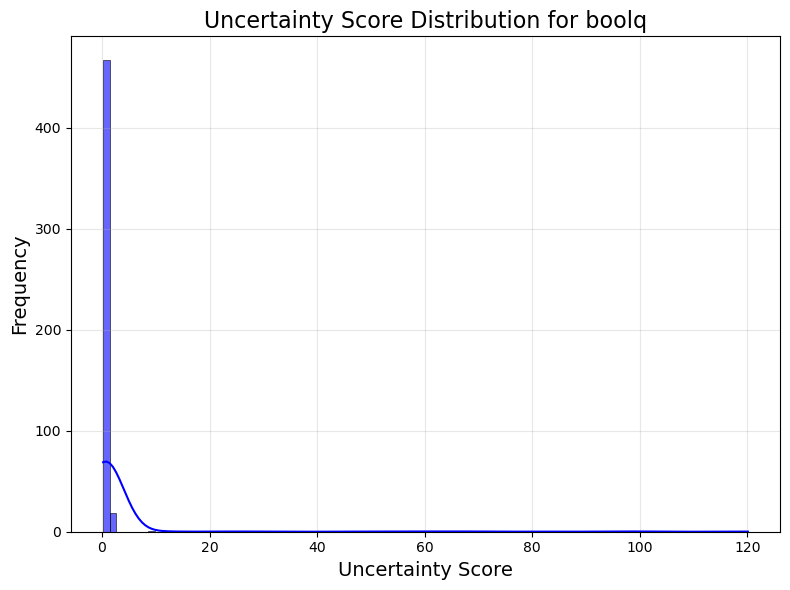

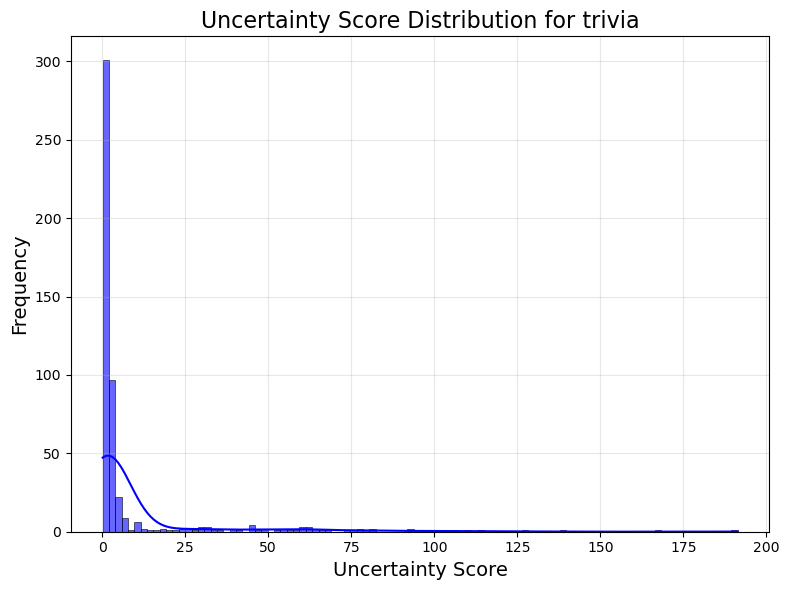

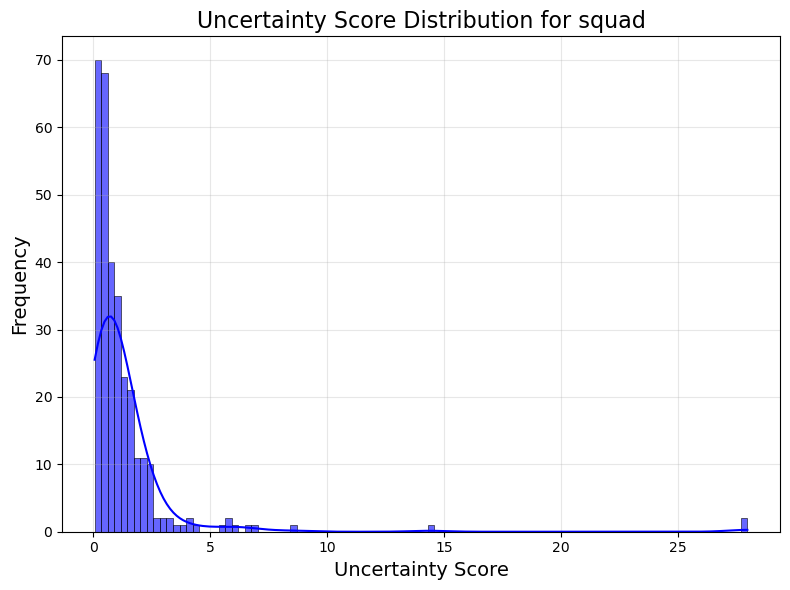

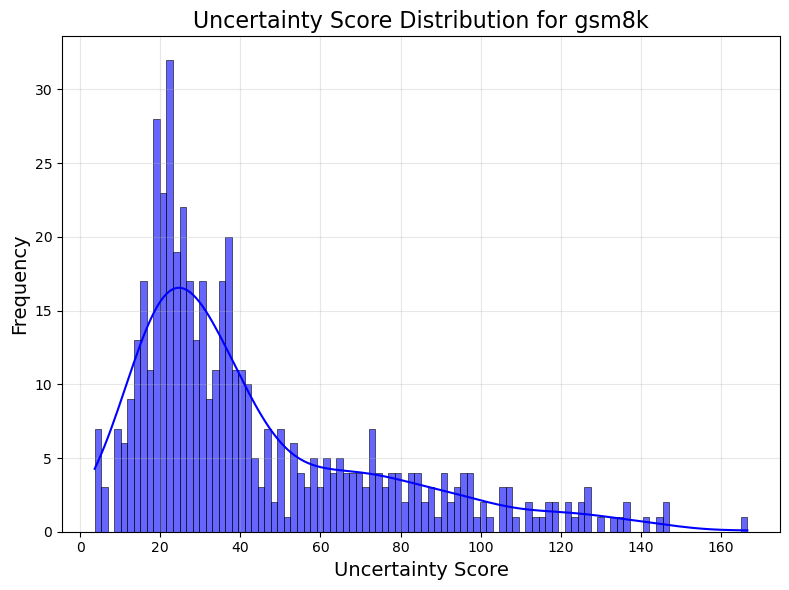

In [27]:
# Plot distribution of uncertainty scores for each dataset
def plot_uncertainty_distribution(df_eval: pd.DataFrame, dataset: str):
    plt.figure(figsize=(8, 6))
    sns.histplot(df_eval["uncertainty_score"], bins=100, kde=True, color='blue', alpha=0.6)
    plt.title(f'Uncertainty Score Distribution for {dataset}', fontsize=16)
    plt.xlabel('Uncertainty Score', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
for ds, df_eval in eval_dfs_msp.items():
    plot_uncertainty_distribution(df_eval, ds)
    # Save each plot
    plt.savefig(os.path.join(SAVE_DIR, f"uncertainty_distribution_{ds}.png"))
    plt.close()  # Close the plot to free memory

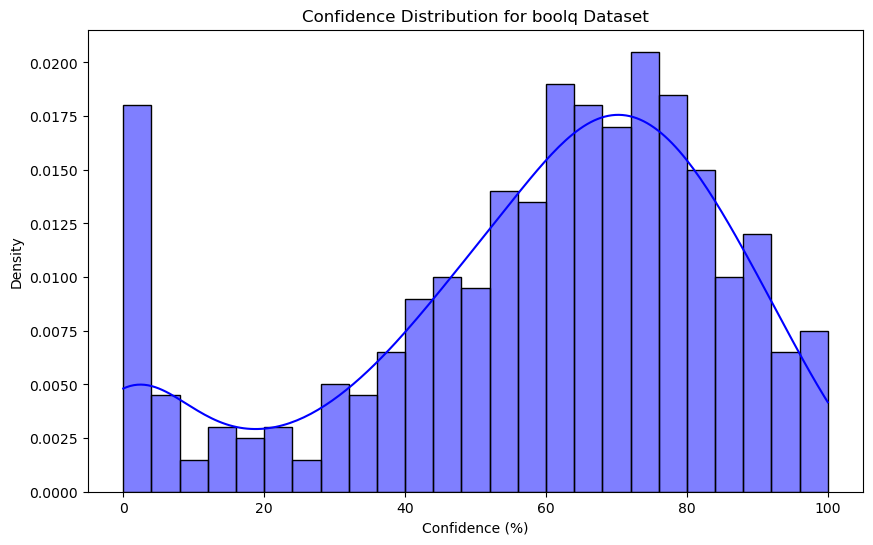

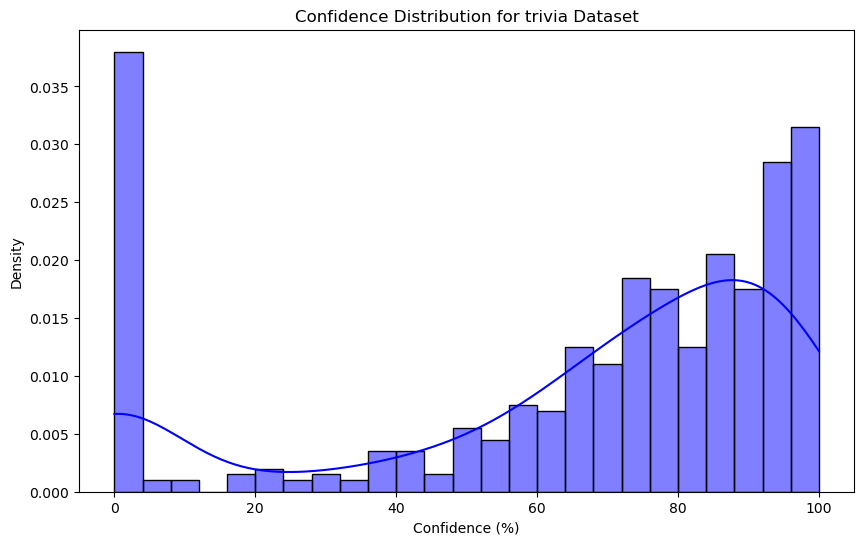

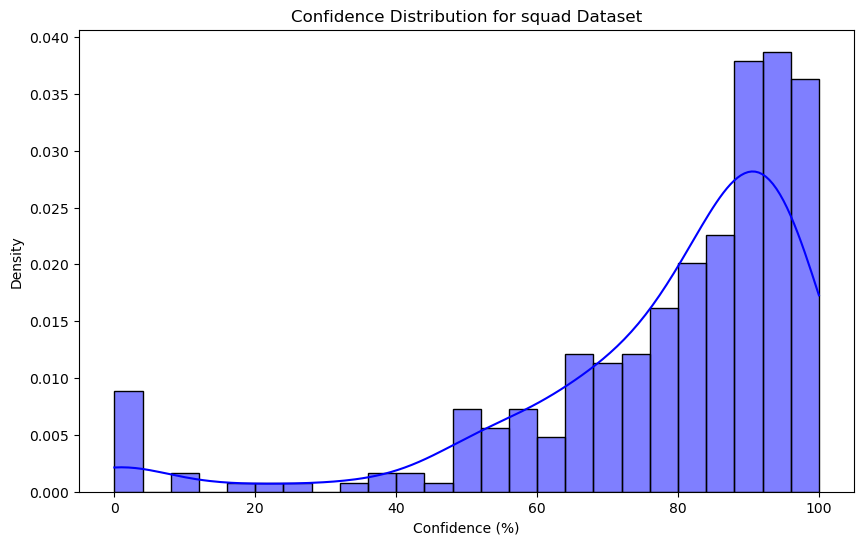

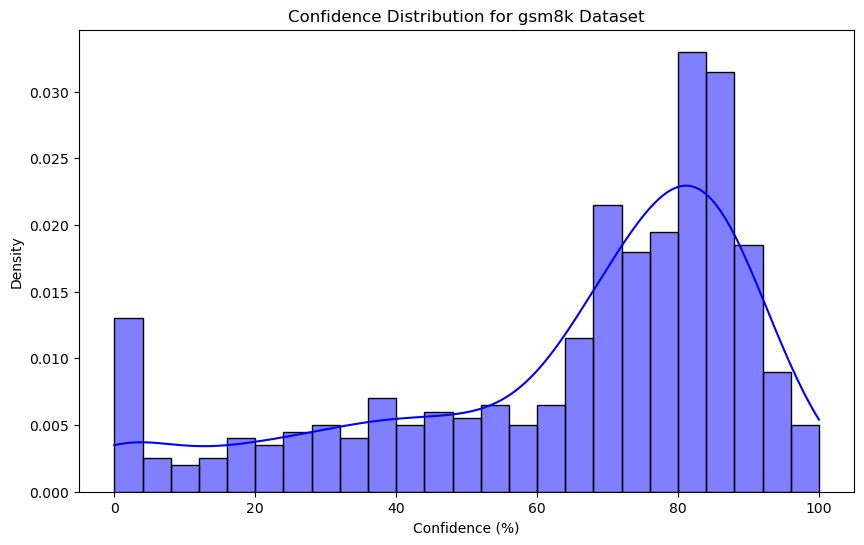

In [23]:
# Plot distribution of confidence for each dataset
def plot_confidence_distribution(df_eval: pd.DataFrame, dataset: str, n_bins: int = 25, filter_min: float = None, filter_max: float = None, save_prefix: str = ""):
    """
    Plot the distribution of confidence scores for a given dataset.
    
    Parameters:
    -----------
    df_eval : pandas.DataFrame
        DataFrame containing parsed confidence scores and correctness information
    dataset : str
        Name of the dataset (e.g., 'boolq', 'trivia', 'squad')
    n_bins : int, default=25
        Number of bins for the histogram
    filter_min : float, optional
        Minimum confidence to include in the plot (default: None)
    filter_max : float, optional
        Maximum confidence to include in the plot (default: None)
    save_prefix : str, default=""
        Prefix for saving the figure file
    """
    
    plt.figure(figsize=(10, 6))
    
    # Filter data if specified
    if filter_min is not None:
        df_eval = df_eval[df_eval["parsed_confidence"] >= filter_min * 100]
    if filter_max is not None:
        df_eval = df_eval[df_eval["parsed_confidence"] <= filter_max * 100]
    
    sns.histplot(df_eval["parsed_confidence"], bins=n_bins, kde=True, stat="density", color="blue", edgecolor="black")
    
    plt.title(f"Confidence Distribution for {dataset} Dataset")
    plt.xlabel("Confidence (%)")
    plt.ylabel("Density")
    
    # Save figure if prefix provided
    # if save_prefix:
    #   plt.savefig(os.path.join(SAVE_DIR, f"{save_prefix}{dataset}_confidence_distribution.png"), dpi=150)
    
    plt.show()

# Plot confidence distribution for each dataset
for ds in ["boolq", "trivia", "squad", "gsm8k"]:
    plot_confidence_distribution(eval_dfs_msp[ds], ds, n_bins=25, filter_min=0.0, filter_max=100.0, save_prefix="msp_")

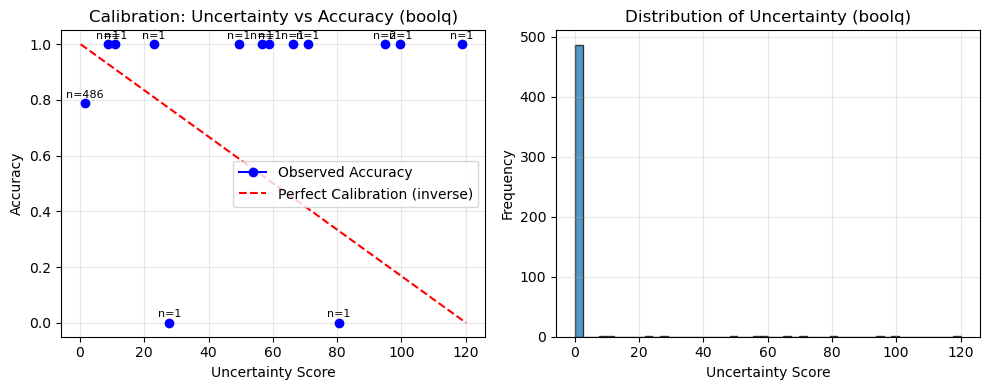

[boolq] corr(uncertainty, -correctness) = -0.024
[boolq] mean uncertainty (correct)   = 2.561
[boolq] mean uncertainty (incorrect) = 1.877


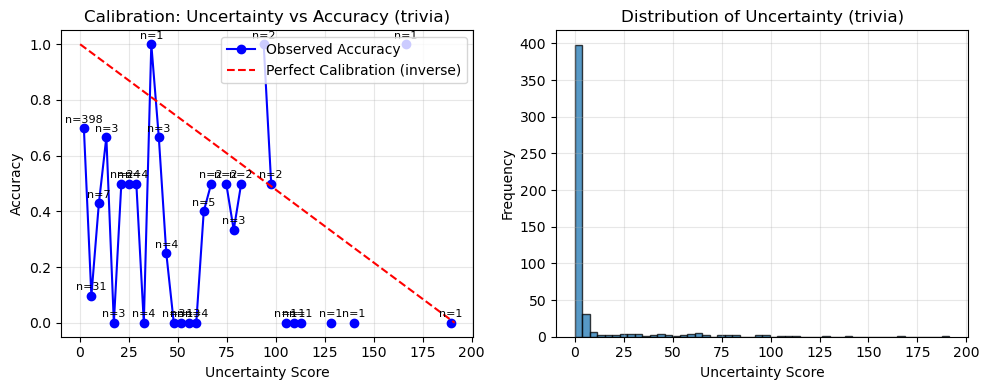

[trivia] corr(uncertainty, -correctness) = 0.219
[trivia] mean uncertainty (correct)   = 5.042
[trivia] mean uncertainty (incorrect) = 15.377


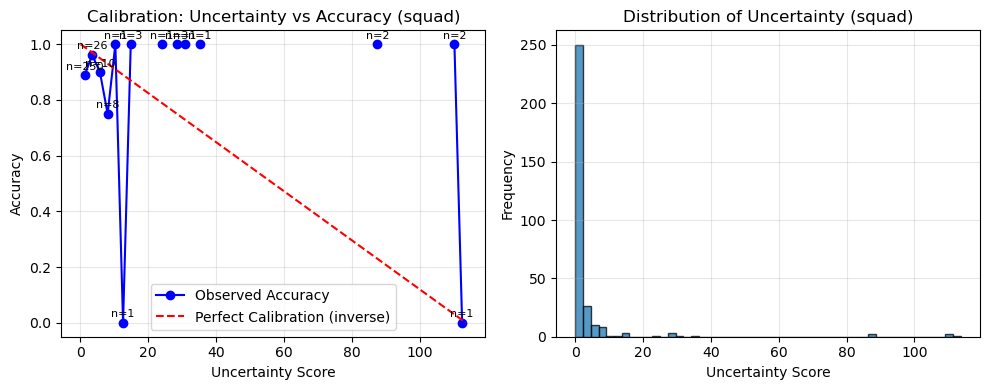

[squad] corr(uncertainty, -correctness) = 0.035
[squad] mean uncertainty (correct)   = 3.677
[squad] mean uncertainty (incorrect) = 5.170


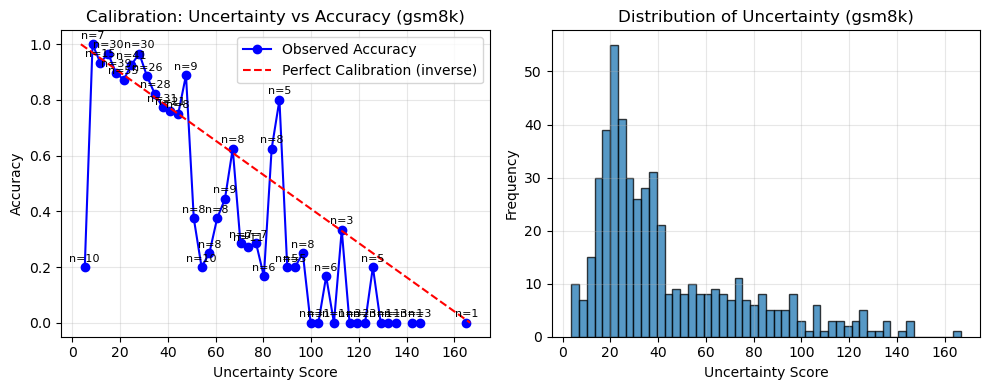

[gsm8k] corr(uncertainty, -correctness) = 0.541
[gsm8k] mean uncertainty (correct)   = 32.116
[gsm8k] mean uncertainty (incorrect) = 68.596


In [21]:
# === Uncertainty calibration plots (Accuracy vs Uncertainty + Histogram) ===
# Per dataset, using ONLY `uncertainty_score`.
# Works with the data frames prepared above: `dfs_raw` (has uncertainty_score) and `eval_dfs` (has is_correct).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

CALIB_SAVE_DIR = os.path.join(SAVE_DIR, "calibration_uncertainty_plots")
os.makedirs(CALIB_SAVE_DIR, exist_ok=True)
CALIB_SAVE_DIR = CALIB_SAVE_DIR.replace("\\", "/")  # force forward slashes

def _assemble_uncertainty_eval_df(dataset: str) -> pd.DataFrame:
    """
    Merge raw uncertainty with correctness from the parser-evaluated df.
    Assumes row order is preserved; if not, attach an explicit row_id before evaluation.
    """
    raw = dfs_raw_msp[dataset].reset_index(drop=True)
    eva = eval_dfs_msp[dataset].reset_index(drop=True)
    if len(raw) != len(eva):
        # If lengths diverge (e.g., parser dropped rows), align by index subset
        n = min(len(raw), len(eva))
        raw = raw.iloc[:n].copy()
        eva = eva.iloc[:n].copy()
    out = pd.DataFrame({
        "uncertainty_score": pd.to_numeric(raw["uncertainty_score"], errors="coerce"),
        "is_correct": eva["is_correct"].astype(float)  # keep NaNs if any
    })
    # Attach parsed answer if available (for optional filtering/inspection)
    if "parsed_answer" in eva.columns:
        out["parsed_answer"] = eva["parsed_answer"]
    return out.dropna(subset=["uncertainty_score", "is_correct"]).reset_index(drop=True)

def plot_uncertainty_calibration(
    df_in: pd.DataFrame,
    dataset: str,
    n_bins: int = 25,
    filter_max: float | None = None,
    save_prefix: str | None = None
):
    """
    Make a 1x2 figure:
      (left) binned accuracy vs. uncertainty (blue line) + inverse "ideal" line
      (right) histogram of uncertainty
    If filter_max is set, restricts to uncertainty_score < filter_max.
    """
    df = df_in.copy()
    if filter_max is not None:
        df = df[df["uncertainty_score"] < filter_max].copy()

    if df.empty:
        print(f"[{dataset}] No data after filtering; skipping.")
        return

    # correlation between uncertainty and *incorrectness* (negative of correctness)
    corr = df["uncertainty_score"].corr(-df["is_correct"])

    # Build bins in *raw* uncertainty space
    u = df["uncertainty_score"].to_numpy()
    y = df["is_correct"].astype(int).to_numpy()

    # Guard: constant-uncertainty edge case
    u_min, u_max = np.nanmin(u), np.nanmax(u)
    if not np.isfinite(u_min) or not np.isfinite(u_max) or u_max <= u_min:
        u_max = u_min + 1e-6

    edges = np.linspace(u_min, u_max, n_bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])

    bin_acc = []
    bin_cnt = []
    for i in range(n_bins):
        if i == n_bins - 1:
            m = (u >= edges[i]) & (u <= edges[i + 1])
        else:
            m = (u >= edges[i]) & (u < edges[i + 1])
        if m.sum() > 0:
            bin_acc.append(y[m].mean())
            bin_cnt.append(int(m.sum()))
        else:
            bin_acc.append(np.nan)
            bin_cnt.append(0)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Left: calibration curve (uncertainty vs. accuracy)
    axes[0].plot(centers, bin_acc, "bo-", label="Observed Accuracy")
    # Heuristic "ideal" inverse trend (purely illustrative)
    axes[0].plot([u_min, u_max], [1.0, 0.0], "r--", label="Perfect Calibration (inverse)")
    axes[0].set_xlabel("Uncertainty Score")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title(f"Calibration: Uncertainty vs Accuracy ({dataset})")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Annotate bin counts
    for x, yv, c in zip(centers, bin_acc, bin_cnt):
        if np.isfinite(yv) and c > 0:
            axes[0].text(x, yv + 0.02, f"n={c}", ha="center", fontsize=8)

    # Right: histogram of uncertainty
    axes[1].hist(df["uncertainty_score"], bins=n_bins, alpha=0.75, edgecolor="black")
    axes[1].set_xlabel("Uncertainty Score")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title(f"Distribution of Uncertainty ({dataset})")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    # Save
    tag = f"{dataset}" + (f"_lt{filter_max:g}" if filter_max is not None else "")
    fname = f"{save_prefix or 'calibration'}_{tag}.png"
    plt.savefig(os.path.join(CALIB_SAVE_DIR, fname).replace("\\", "/"), dpi=300, bbox_inches="tight")
    plt.show()

    # Print small summary
    print(f"[{dataset}] corr(uncertainty, -correctness) = {corr:.3f}")
    print(f"[{dataset}] mean uncertainty (correct)   = {df[df['is_correct']==1]['uncertainty_score'].mean():.3f}")
    print(f"[{dataset}] mean uncertainty (incorrect) = {df[df['is_correct']==0]['uncertainty_score'].mean():.3f}")

# -------------------------
# Build uncertainty+correctness frames and plot for each dataset
# -------------------------
unc_eval_msp = {ds: _assemble_uncertainty_eval_df(ds) for ds in ["boolq","trivia","squad", "gsm8k"]}

# Full-range plots
for ds in ["boolq","trivia","squad", "gsm8k"]:
    plot_uncertainty_calibration(unc_eval_msp[ds], ds, n_bins=50, filter_max=None, save_prefix="calibration_unc")

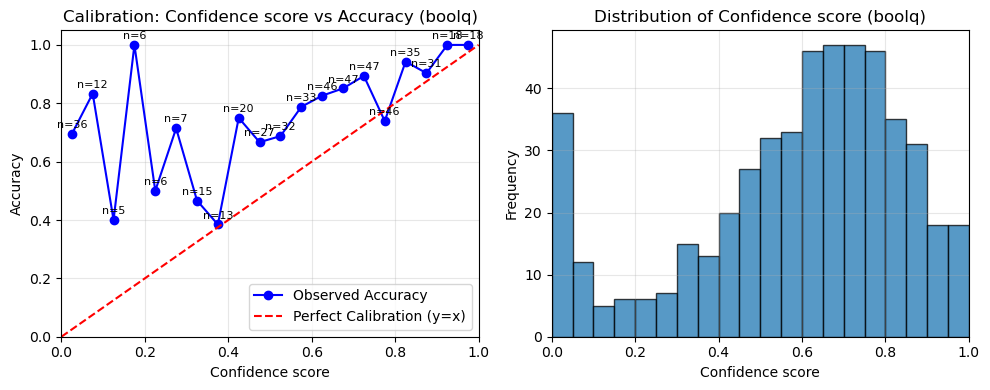

[boolq] corr(confidence, correctness) = 0.217
[boolq] mean confidence (correct)   = 0.616
[boolq] mean confidence (incorrect) = 0.477


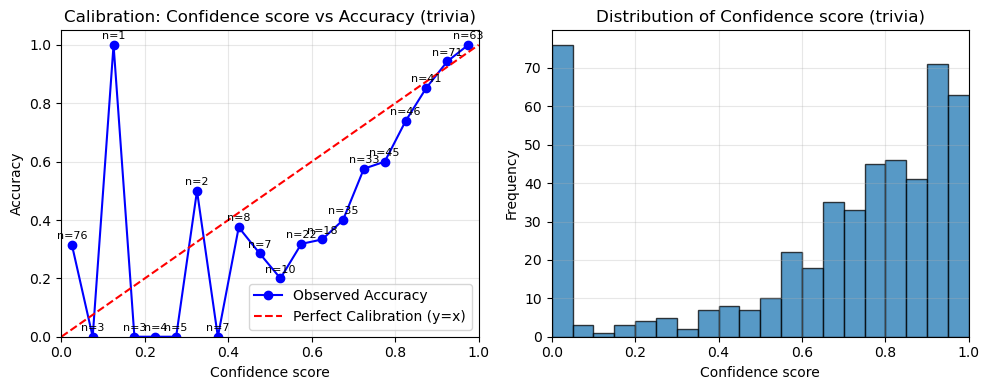

[trivia] corr(confidence, correctness) = 0.494
[trivia] mean confidence (correct)   = 0.781
[trivia] mean confidence (incorrect) = 0.449


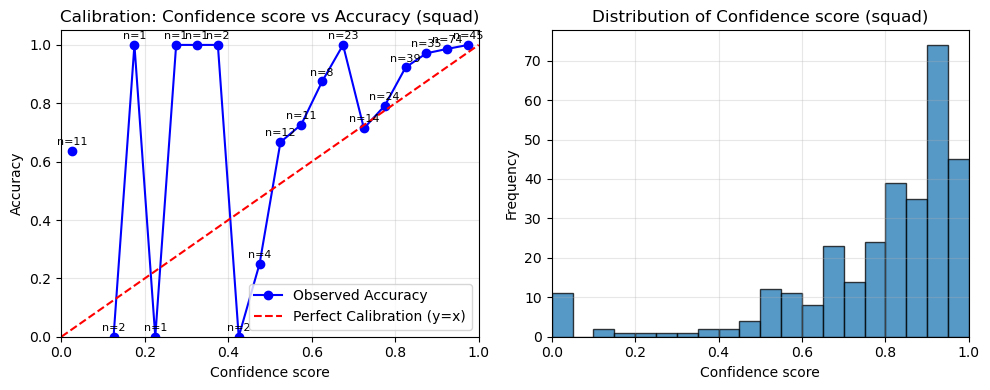

[squad] corr(confidence, correctness) = 0.390
[squad] mean confidence (correct)   = 0.811
[squad] mean confidence (incorrect) = 0.534


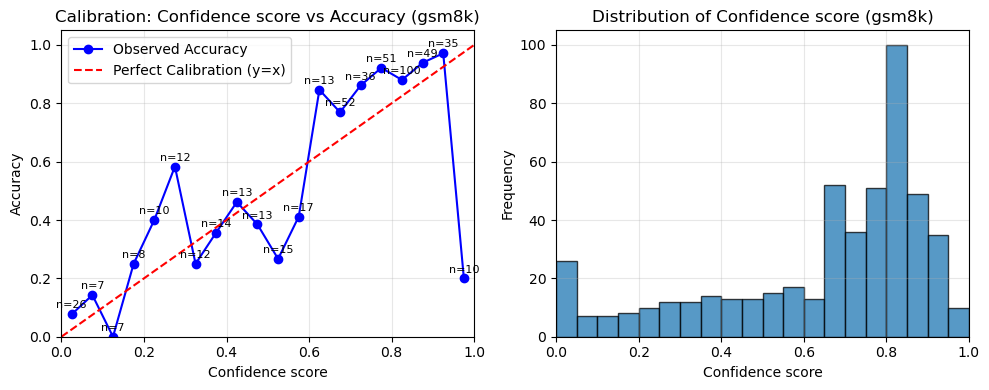

[gsm8k] corr(confidence, correctness) = 0.542
[gsm8k] mean confidence (correct)   = 0.741
[gsm8k] mean confidence (incorrect) = 0.432


In [22]:
# === Confidence-based calibration plots (like the uncertainty plots, but using confidence) ===
# Uses the "confidence score formed earlier": `parsed_confidence` in eval_dfs[ds] (0..100).
# Left: binned Accuracy vs Confidence with perfect-calibration y=x
# Right: histogram of confidence.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CALIB_CONF_SAVE_DIR = os.path.join(SAVE_DIR, "calibration_confidence_plots")
os.makedirs(CALIB_CONF_SAVE_DIR, exist_ok=True)

def _get_conf_eval_df(dataset: str) -> pd.DataFrame:
    """
    Pull the evaluated frame and keep only the columns we need.
    Assumes eval_dfs[dataset] exists and has parsed_confidence (0..100) + is_correct.
    """
    d = eval_dfs_msp[dataset].copy()
    d = d.dropna(subset=["parsed_confidence", "is_correct"])
    d["conf01"] = pd.to_numeric(d["parsed_confidence"], errors="coerce").clip(0, 100) / 100.0
    d["is_correct"] = d["is_correct"].astype(int)
    return d[["conf01", "is_correct"]].reset_index(drop=True)

def plot_confidence_calibration(
    dataset: str,
    n_bins: int = 25,
    filter_min: float | None = None,
    filter_max: float | None = None,
    save_prefix: str = "calibration_conf"
):
    """
    Make 1x2 figure for a dataset using confidence:
      (left) binned accuracy vs confidence with y=x;
      (right) histogram of confidence.
    filter_min/max are in [0,1] for confidence (e.g., filter_min=0.1, filter_max=0.95).
    """
    df = _get_conf_eval_df(dataset)

    # Optional range filtering on confidence
    if filter_min is not None:
        df = df[df["conf01"] >= float(filter_min)]
    if filter_max is not None:
        df = df[df["conf01"] <= float(filter_max)]

    if df.empty:
        print(f"[{dataset}] No data after filtering; skipping.")
        return

    conf = df["conf01"].to_numpy()
    corr = df["conf01"].corr(df["is_correct"])  # correlation(confidence, correctness)

    # Build equal-width bins in confidence space
    edges = np.linspace(conf.min(), conf.max(), n_bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])

    bin_acc, bin_cnt = [], []
    y = df["is_correct"].to_numpy()

    for i in range(n_bins):
        if i == n_bins - 1:
            m = (conf >= edges[i]) & (conf <= edges[i+1])
        else:
            m = (conf >= edges[i]) & (conf < edges[i+1])
        if m.sum() > 0:
            bin_acc.append(y[m].mean())
            bin_cnt.append(int(m.sum()))
        else:
            bin_acc.append(np.nan)
            bin_cnt.append(0)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Left: calibration curve (confidence vs accuracy) with y=x
    axes[0].plot(centers, bin_acc, "bo-", label="Observed Accuracy")
    if filter_min is not None or filter_max is not None:
        axes[0].set_xlim(float(filter_min or 0), float(filter_max or 1))
        # Replot the perfect line with the same limits
        axes[0].plot([float(filter_min or 0), float(filter_max or 1)], [0, 1], "r--")
    else:
        axes[0].set_xlim(0, 1)
        axes[0].plot([0, 1], [0, 1], "r--", label="Perfect Calibration (y=x)")
    axes[0].set_ylim(0, 1.05)
    axes[0].set_xlabel("Confidence score")
    axes[0].set_ylabel("Accuracy")
    title_tag = f"{dataset}" + (f" [{filter_min or 0:.2f}–{filter_max or 1:.2f}]" if (filter_min is not None or filter_max is not None) else "")
    axes[0].set_title(f"Calibration: Confidence score vs Accuracy ({title_tag})")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Annotate counts
    for x, yv, c in zip(centers, bin_acc, bin_cnt):
        if np.isfinite(yv) and c > 0:
            axes[0].text(x, min(1.02, yv + 0.02), f"n={c}", ha="center", fontsize=8)

    # Right: histogram of confidence
    axes[1].hist(df["conf01"], bins=n_bins, alpha=0.75, edgecolor="black")
    if filter_min is not None or filter_max is not None:
        axes[1].set_xlim(float(filter_min or 0), float(filter_max or 1))
    else:
        axes[1].set_xlim(0, 1)
    axes[1].set_xlabel("Confidence score")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title(f"Distribution of Confidence score ({dataset})")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    fname = f"{save_prefix}_{dataset}"
    if filter_min is not None or filter_max is not None:
        lo = 0.0 if filter_min is None else float(filter_min)
        hi = 1.0 if filter_max is None else float(filter_max)
        fname += f"_range_{lo:.2f}_{hi:.2f}"
    plt.savefig(os.path.join(CALIB_CONF_SAVE_DIR, f"{fname}.png"), dpi=300, bbox_inches="tight")
    plt.show()

    # Summary lines
    print(f"[{dataset}] corr(confidence, correctness) = {corr:.3f}")
    print(f"[{dataset}] mean confidence (correct)   = {df[df['is_correct']==1]['conf01'].mean():.3f}")
    print(f"[{dataset}] mean confidence (incorrect) = {df[df['is_correct']==0]['conf01'].mean():.3f}")

# --- Generate plots for all datasets ---
for ds in ["boolq","trivia","squad", "gsm8k"]:
    # Full range
    plot_confidence_calibration(ds, n_bins=20, filter_min=None, filter_max=None, save_prefix="calibration_conf")
